In [2]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import json
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MultiLabelBinarizer
import time
from scipy import stats
from scipy.spatial import distance
#import chime
#import ijson

import psycopg2
from pymongo import MongoClient

from funk_svd import SVD 

# Data Load

In [3]:
client = MongoClient(host='10.10.224.28',
                     port=27017,
                     username='vida',
                     password='qwer123$')

db_datamart = client['datamart']

In [4]:
collection = db_datamart['dm_orderseries']
temp = collection.find()
dataframe_orderseries = DataFrame(temp)

In [5]:
collection = db_datamart['dm_merchandise']
temp = collection.find({'productId': {'$in' : list(dataframe_orderseries['productId'])}})
dataframe_merchandise = DataFrame(temp)


KeyboardInterrupt



In [ ]:
collection = db_datamart['dm_buyer']
temp = collection.find()
dataframe_buyer = DataFrame(temp)

# DataEDA

## 고객군 클러스터링

### (1) Order Product의 제품 Category 기반 고객군 클러스터링

지난번 진행한 클러스터링은 모두 45000개에 달하는 전체 상품을 중심으로 Buyer 클러스터링 하려 시도하였다.

하지만, Buyer를 클러스터링 할 때, 상품 자체보다는 '상품 카테고리'가 더 유의미할 가능성이 높다. 즉, 아동복 매장은 보통 아동복만 팔 것이며, 신사복을 파는 가게는 신사복만 팔 확률이 높다.

**가설 : Column을 상품에서 상품의 카테고리로 축소하면, 유의미한 클러스터링이 가능할 것이다.**

In [6]:
merchandise = dataframe_merchandise.copy()

In [7]:
def type_extractor(x, types, recursive=None):
    try:
        if recursive is None:
            return x[0][types]
        else:
            return type_extractor([x[0][types]],
                                  types=recursive)
    except:
        return 'NaN'

In [8]:
merchandise['category'] = \
merchandise['SKUdata'].apply(lambda x : type_extractor(
                                                    type_extractor([x], 
                                                                   'data', 
                                                                   recursive='categoryPath'),
                                                    'en'))

In [9]:
merchandise['cat_0'] = merchandise['category'].apply(lambda x : x[0])
merchandise['cat_1'] = merchandise['category'].apply(lambda x : x[1])
merchandise['cat_2'] = merchandise['category'].apply(lambda x : x[2] if len(x) > 2 else None)

In [10]:
merchandise['prodName'] = merchandise['SKUdata'].apply(lambda x : type_extractor([x], 'name', recursive = 'ko'))

#### - 데이터 절단

In [ ]:
merchandise_reduced = merchandise[['productId','prodName','cat_0','cat_1','cat_2']]

In [ ]:
merchandise_reduced = merchandise_reduced.drop_duplicates()

In [ ]:
orderseries_merchandise = \
pd.merge(dataframe_orderseries,
         merchandise_reduced,
         on = 'productId',
        how = 'inner')

In [ ]:
orderseries_merchandise = orderseries_merchandise[orderseries_merchandise['cat_2'] != 'N']

In [117]:
temp = orderseries_merchandise.groupby('buyerId')['cat_0'].value_counts()

temp = temp.reset_index(name = 'count')

temp_cat0 = temp.pivot(index = 'buyerId', columns='cat_0', values = 'count').fillna(0)

temp_cat0 = temp_cat0.reset_index()

In [118]:
temp = orderseries_merchandise.groupby('buyerId')['cat_1'].value_counts()

temp = temp.reset_index(name = 'count')

temp_cat1 = temp.pivot(index = 'buyerId', columns='cat_1', values = 'count').fillna(0)

temp_cat1 = temp_cat1.reset_index()

In [119]:
temp = orderseries_merchandise.groupby('buyerId')['cat_2'].value_counts()

temp = temp.reset_index(name = 'count')

temp_cat2 = temp.pivot(index = 'buyerId', columns='cat_2', values = 'count').fillna(0)

temp_cat2 = temp_cat2.reset_index()

데이터를 확인해보면, 38개 Middle 카테고리 중 buyer가 전체 통틀어서 한, 두건 구매한 사례들도 제법 보인다.

이 사례들은 분석시 클러스터를 하기 어려운 문제를 야기할 수도 있다.

제거가 필요한데, 이를 위해 타당한 기준 수립이 필요하다

In [120]:
def min_max_scailing(x, except_col):
    if except_col is not None:
        max_value = np.max(x.drop([except_col]))
        min_value = np.min(x.drop([except_col]))
        temp = (x.drop([except_col]) - min_value) / (max_value - min_value)
        temp = DataFrame(temp).T
        return pd.concat([DataFrame(x[[except_col]]).T, temp], axis = 1)
    else :
        max_value = np.max(x)
        min_value = np.min(x)
        temp = (x - min_value) / (max_value - min_value)
        #temp = DataFrame(temp).T
        return temp

단순히 한 ~ 두개만 구매한 바이어만 제외하자니, 몇가지 고려사항이 필요하다

- [1,1,1,1,1....]로 구매한 바이어 : 이 경우, 각 카테고리별로 한건씩만 구매했지만, 어찌됐든 총량으로는 꽤 많은(최대 38개) 물품을 구매한 바이어다



목적은, 
- 구매이력의 특정 카테고리 집중도와
- 최댓값을 모두 고려하여 낮은 점수의 사례들을 제외하되, 
- 그 갯수를 최소화하여 손실을 줄인다

##### cat_0

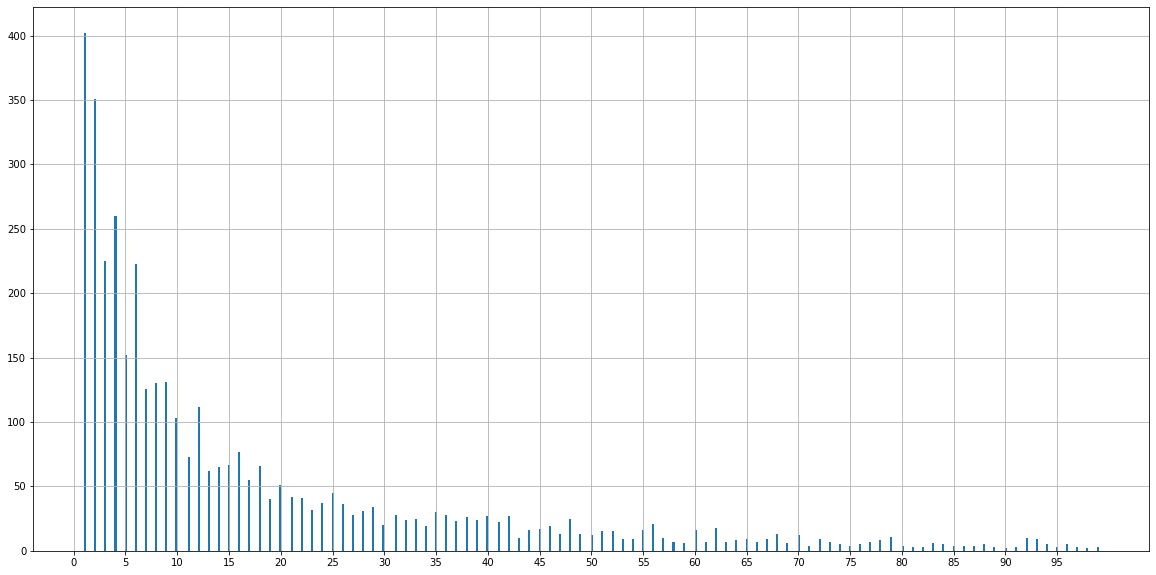

In [122]:
plt.figure(figsize = (20,10))
temp_cat0.iloc[:,1:].apply(lambda x : max(x) if max(x) < 100 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,100,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = {\max{X_{i}}} $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$

최댓값만 고려하였을땐 위에서 선언한 목적에서 다음의 사안을 위반한다

- 집중도 미반영
- 손실 갯수 최소화 : 계급값 2 이하를 제외한다해도 약 800개의 샘플이 손실된다.

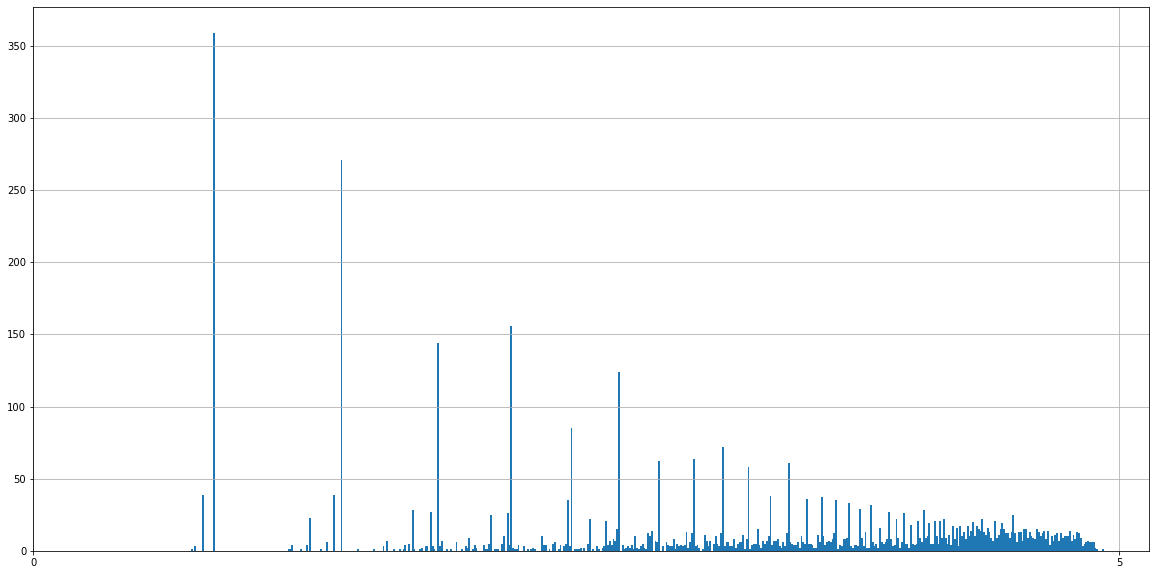

In [123]:
plt.figure(figsize = (20,10))
temp_cat0.iloc[:,1:].apply(lambda x : max(x) / (np.std(x) + 1) if max(x) / (np.std(x) + 1) < 10 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,10,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = {\max{X_{i}} \over std(X_{i}) + 1} $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$
$$ std 는 표준편차 $$

심플한 착안으로, 

- 해당 바이어의 구매 이력이 고르게 퍼져있을수록(=표준편차가 작을수록) 값이 커지고, 특정 값에 몰려있을수록(=표준 편차가 클수록) 값이 작아진다

- 여기에 해당 바이어 구매 이력의 최댓값(max X_i)를 가져와서 최댓값이 클수록 값이 커진다.

최댓값만 고려하였을땐 위에서 선언한 목적에서 다음의 사안을 위반한다

- 손실 갯수 최소화 : 대부분의 값이 0 ~ 5 사이에 몰려있어 너무 많은 샘플을 손실할 우려가 존재한다

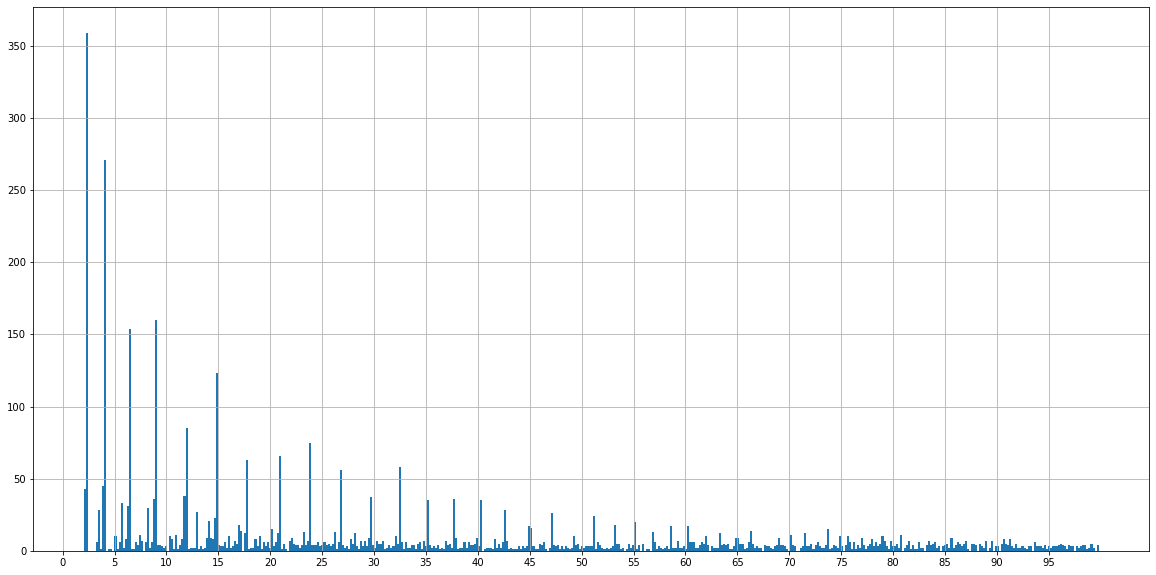

In [127]:
plt.figure(figsize = (20,10))
temp_cat0.iloc[:,1:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)) 
                      if np.exp(max(x) / (np.std(x) + 1)) < 100 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,100,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = exp({\max{X_{i}} \over std(X_{i}) + 1}) $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$
$$ std 는 표준편차 $$

바로 위 변환 수식을 지수변환하여 저점수 / 고점수간 계급값 차이를 극대화한다

In [131]:
temp_cat0['values'] = temp_cat0.iloc[:,1:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)), axis = 1)

In [132]:
temp_cat0['values'].describe()

count    4218.000000
mean       41.378641
std        26.733312
min         3.857572
25%        15.748145
50%        39.941375
75%        64.489162
max       153.351140
Name: values, dtype: float64

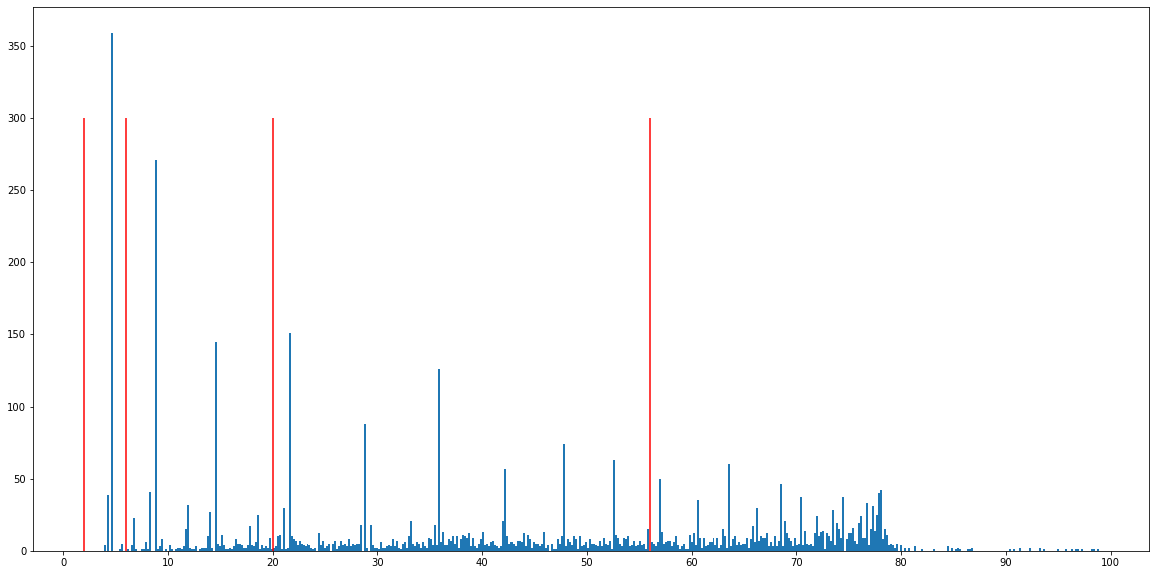

In [139]:
plt.figure(figsize = (20,10))
plt.hist(temp_cat0.loc[temp_cat0['values'] < 100, 'values'], bins = 500)
plt.xticks(range(0, 220, 10))
plt.vlines([2,6,20,56], ymin = 0, ymax = 300, color = 'red')
plt.show()

In [140]:
(temp_cat0['values'] >= 6).value_counts()

True     3810
False     408
Name: values, dtype: int64

In [142]:
temp_cat0 = temp_cat0[temp_cat0['values'] >= 6]
temp_cat0 = temp_cat0.drop(['values'], axis = 1)

In [143]:
def softmax_function(x):
    max_val = np.max(x)
    denominator = np.sum(np.exp(x - max_val))
    numerator = np.exp(x - max_val)
    return numerator / denominator

In [144]:
temp_cat0_softmax = temp_cat0.iloc[:,1:].apply(lambda x : softmax_function(x), axis = 1)

##### cat_1

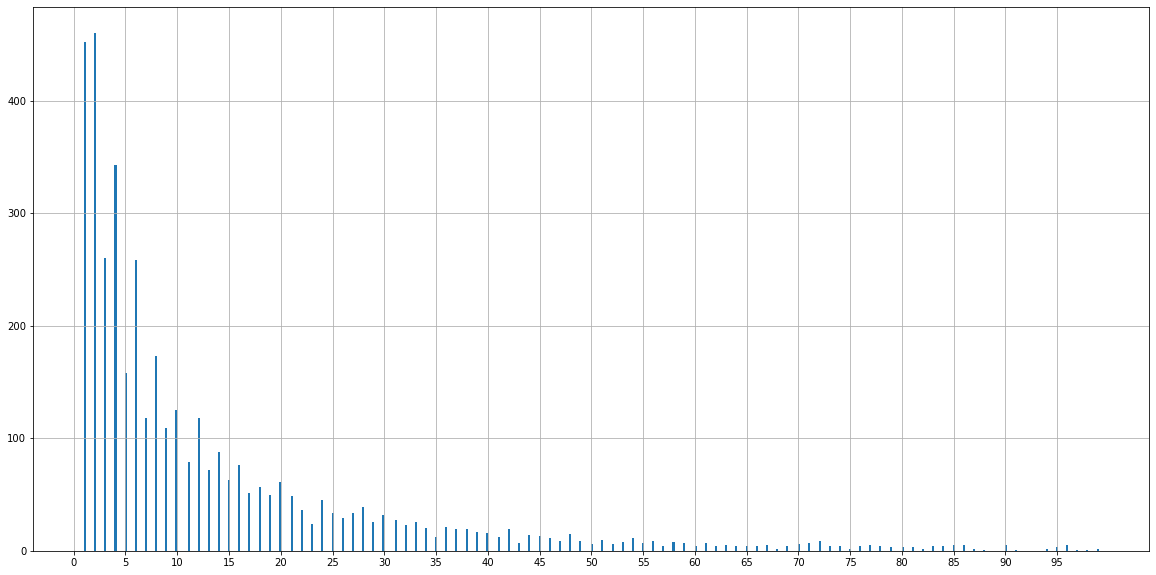

In [30]:
plt.figure(figsize = (20,10))
temp_cat1.iloc[:,1:].apply(lambda x : max(x) if max(x) < 100 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,100,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = {\max{X_{i}}} $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$

최댓값만 고려하였을땐 위에서 선언한 목적에서 다음의 사안을 위반한다

- 집중도 미반영
- 손실 갯수 최소화 : 계급값 2 이하를 제외한다해도 약 800개의 샘플이 손실된다.

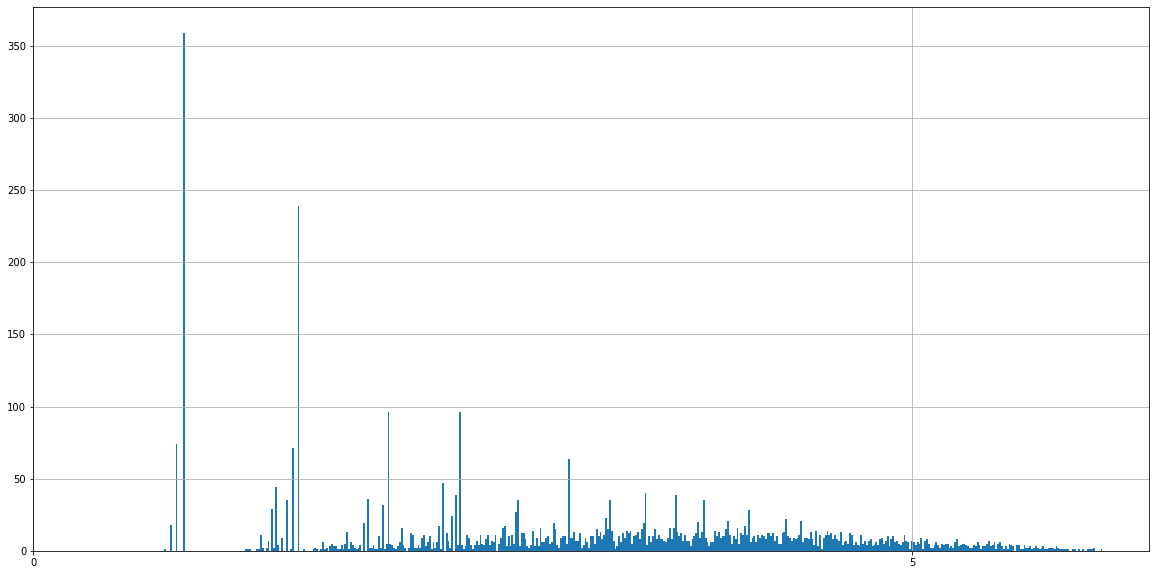

In [32]:
plt.figure(figsize = (20,10))
temp_cat1.iloc[:,1:].apply(lambda x : max(x) / (np.std(x) + 1) if max(x) / (np.std(x) + 1) < 10 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,10,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = {\max{X_{i}} \over std(X_{i}) + 1} $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$
$$ std 는 표준편차 $$

심플한 착안으로, 

- 해당 바이어의 구매 이력이 고르게 퍼져있을수록(=표준편차가 작을수록) 값이 커지고, 특정 값에 몰려있을수록(=표준 편차가 클수록) 값이 작아진다

- 여기에 해당 바이어 구매 이력의 최댓값(max X_i)를 가져와서 최댓값이 클수록 값이 커진다.

최댓값만 고려하였을땐 위에서 선언한 목적에서 다음의 사안을 위반한다

- 손실 갯수 최소화 : 대부분의 값이 0 ~ 5 사이에 몰려있어 너무 많은 샘플을 손실할 우려가 존재한다

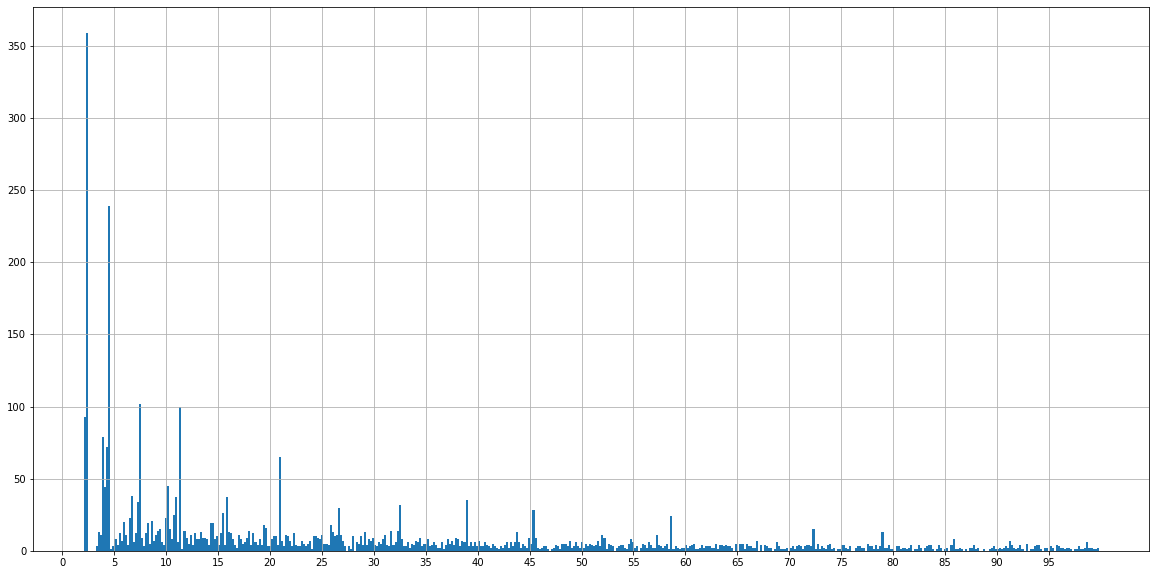

In [34]:
plt.figure(figsize = (20,10))
temp_cat1.iloc[:,1:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)) 
                      if np.exp(max(x) / (np.std(x) + 1)) < 100 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,100,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = exp({\max{X_{i}} \over std(X_{i}) + 1}) $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$
$$ std 는 표준편차 $$

바로 위 변환 수식을 지수변환하여 저점수 / 고점수간 계급값 차이를 극대화한다

In [145]:
temp_cat1['values'] = temp_cat1.iloc[:,1:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)), axis = 1)

In [146]:
temp_cat1['values'].describe()

count    4218.000000
mean       45.345800
std        61.213226
min         2.106926
25%         7.120974
50%        20.928166
75%        57.495963
max       438.125415
Name: values, dtype: float64

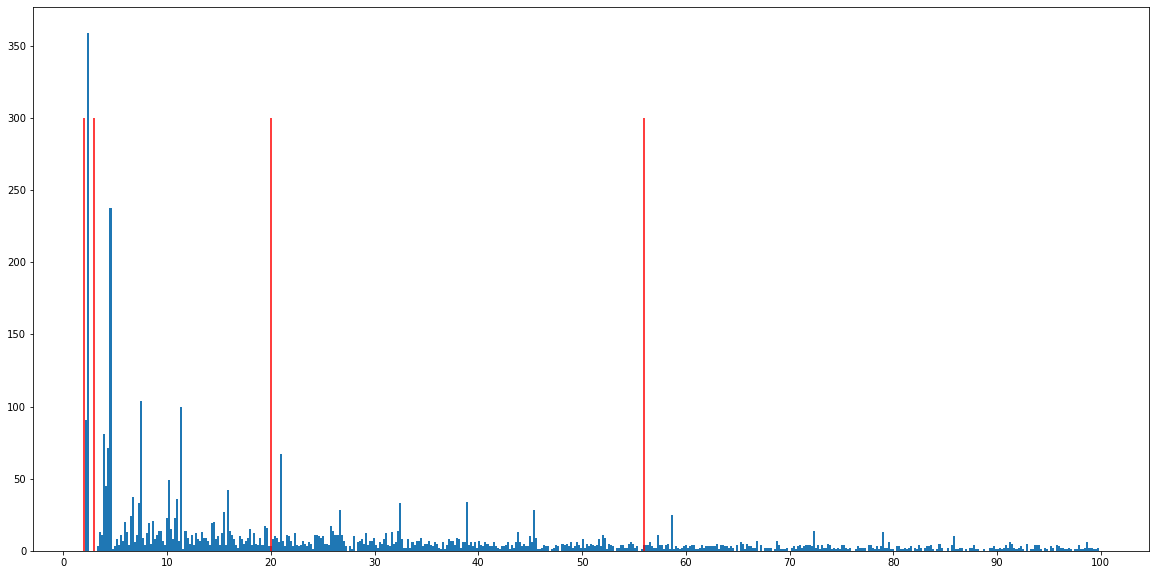

In [147]:
plt.figure(figsize = (20,10))
plt.hist(temp_cat1.loc[temp_cat1['values'] < 100, 'values'], bins = 500)
plt.xticks(range(0, 220, 10))
plt.vlines([2,3,20,56], ymin = 0, ymax = 300, color = 'red')
plt.show()

In [148]:
(temp_cat1['values'] >= 3).value_counts()

True     3768
False     450
Name: values, dtype: int64

In [149]:
temp_cat1 = temp_cat1[temp_cat1['values'] >= 3]
temp_cat1 = temp_cat1.drop(['values'], axis = 1)

In [150]:
def softmax_function(x):
    max_val = np.max(x)
    denominator = np.sum(np.exp(x - max_val))
    numerator = np.exp(x - max_val)
    return numerator / denominator

In [151]:
temp_cat1_softmax = temp_cat1.iloc[:,1:].apply(lambda x : softmax_function(x), axis = 1)

In [24]:
def animate(i):
    ax.view_init(elev=30., azim=i)
    return fig,

##### cat_2

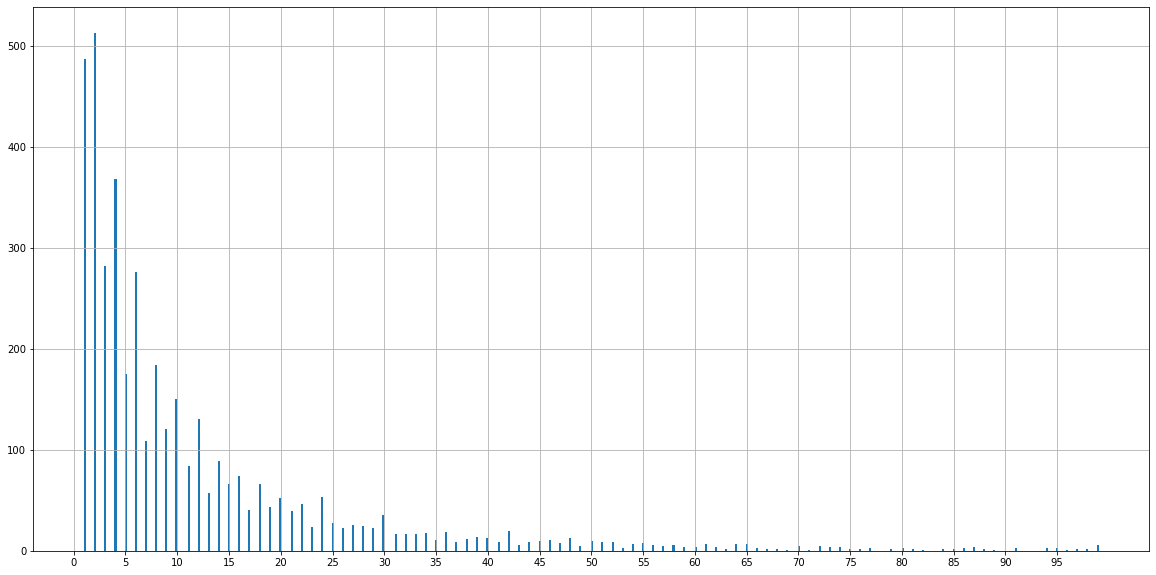

In [152]:
plt.figure(figsize = (20,10))
temp_cat2.iloc[:,1:].apply(lambda x : max(x) if max(x) < 100 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,100,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = {\max{X_{i}}} $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$

최댓값만 고려하였을땐 위에서 선언한 목적에서 다음의 사안을 위반한다

- 집중도 미반영
- 손실 갯수 최소화 : 계급값 2 이하를 제외한다해도 약 800개의 샘플이 손실된다.

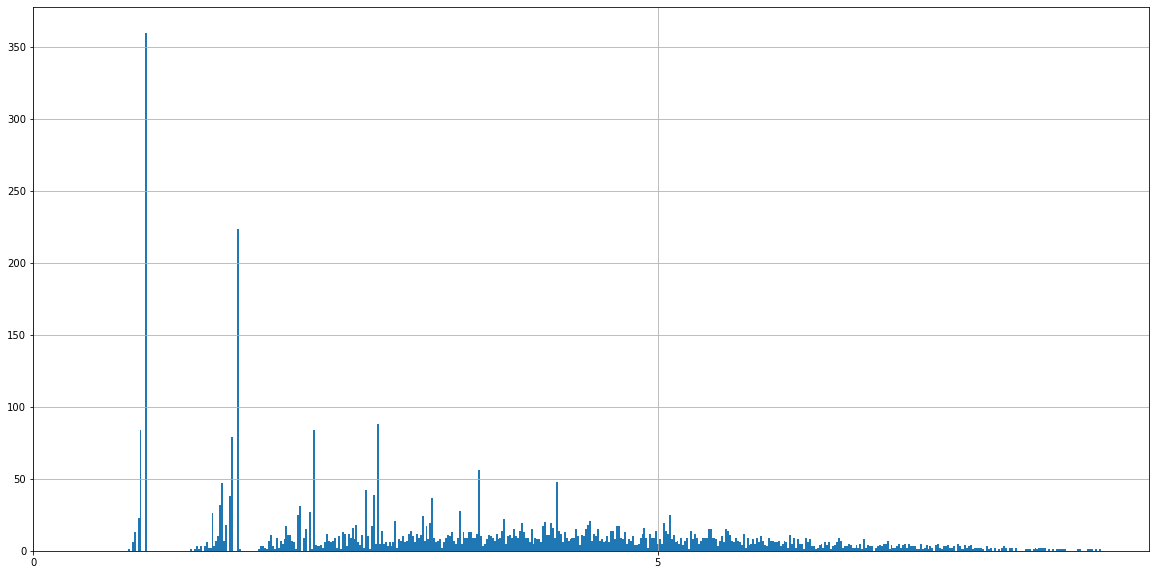

In [153]:
plt.figure(figsize = (20,10))
temp_cat2.iloc[:,1:].apply(lambda x : max(x) / (np.std(x) + 1) if max(x) / (np.std(x) + 1) < 10 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,10,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = {\max{X_{i}} \over std(X_{i}) + 1} $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$
$$ std 는 표준편차 $$

심플한 착안으로, 

- 해당 바이어의 구매 이력이 고르게 퍼져있을수록(=표준편차가 작을수록) 값이 커지고, 특정 값에 몰려있을수록(=표준 편차가 클수록) 값이 작아진다

- 여기에 해당 바이어 구매 이력의 최댓값(max X_i)를 가져와서 최댓값이 클수록 값이 커진다.

최댓값만 고려하였을땐 위에서 선언한 목적에서 다음의 사안을 위반한다

- 손실 갯수 최소화 : 대부분의 값이 0 ~ 5 사이에 몰려있어 너무 많은 샘플을 손실할 우려가 존재한다

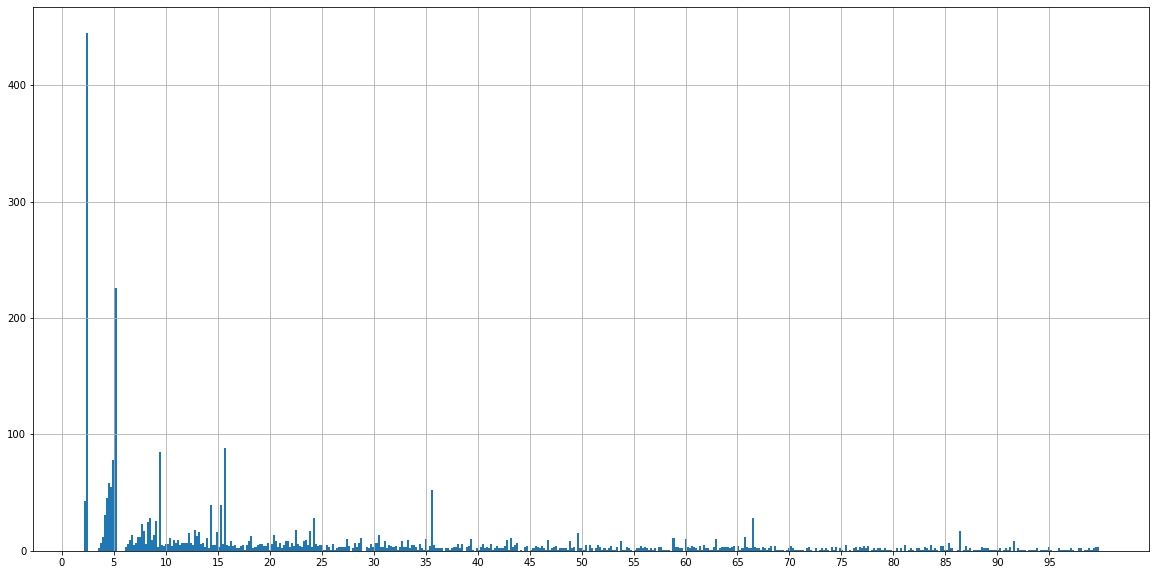

In [35]:
plt.figure(figsize = (20,10))
temp_cat2.iloc[:,1:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)) 
                      if np.exp(max(x) / (np.std(x) + 1)) < 100 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,100,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = exp({\max{X_{i}} \over std(X_{i}) + 1}) $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$
$$ std 는 표준편차 $$

바로 위 변환 수식을 지수변환하여 저점수 / 고점수간 계급값 차이를 극대화한다

In [154]:
temp_cat2['values'] = temp_cat2.iloc[:,1:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)), axis = 1)

In [155]:
temp_cat2['values'].describe()

count    4198.000000
mean      167.600946
std       431.369465
min         2.131533
25%         7.279390
50%        30.125075
75%       121.521343
max      5143.409376
Name: values, dtype: float64

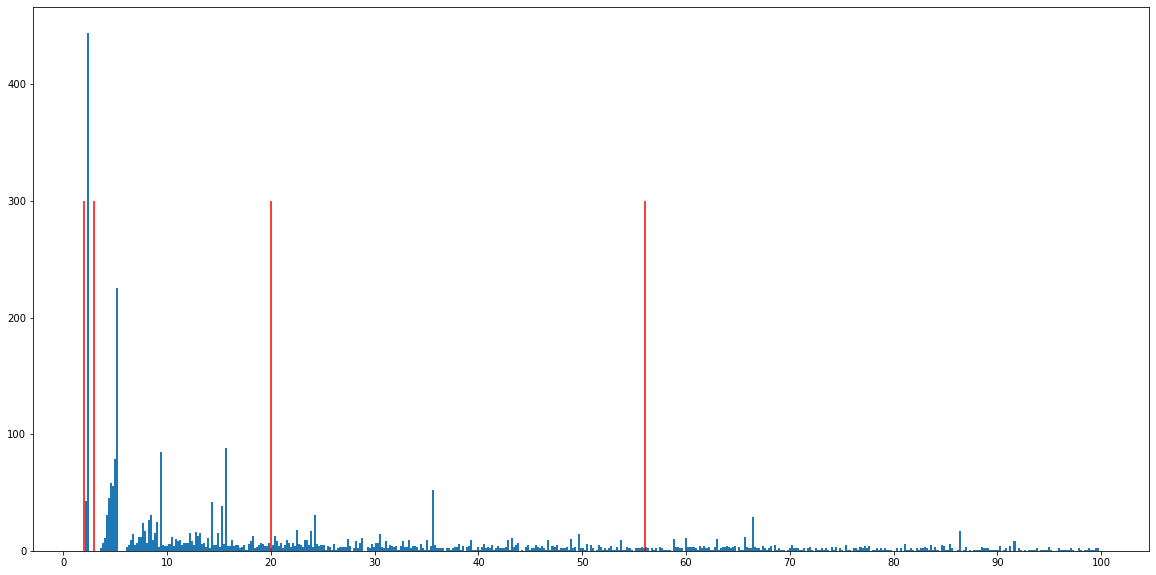

In [156]:
plt.figure(figsize = (20,10))
plt.hist(temp_cat2.loc[temp_cat2['values'] < 100, 'values'], bins = 500)
plt.xticks(range(0, 220, 10))
plt.vlines([2,3,20,56], ymin = 0, ymax = 300, color = 'red')
plt.show()

In [157]:
(temp_cat2['values'] >= 3).value_counts()

True     3711
False     487
Name: values, dtype: int64

In [158]:
temp_cat2 = temp_cat2[temp_cat2['values'] >= 3]
temp_cat2 = temp_cat2.drop(['values'], axis = 1)

In [159]:
def softmax_function(x):
    max_val = np.max(x)
    denominator = np.sum(np.exp(x - max_val))
    numerator = np.exp(x - max_val)
    return numerator / denominator

In [160]:
temp_cat2_softmax = temp_cat2.iloc[:,1:].apply(lambda x : softmax_function(x), axis = 1)

In [161]:
def animate(i):
    ax.view_init(elev=30., azim=i)
    return fig,

#### TSNE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_3196\1738368451.py:22: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter ffmpeg u

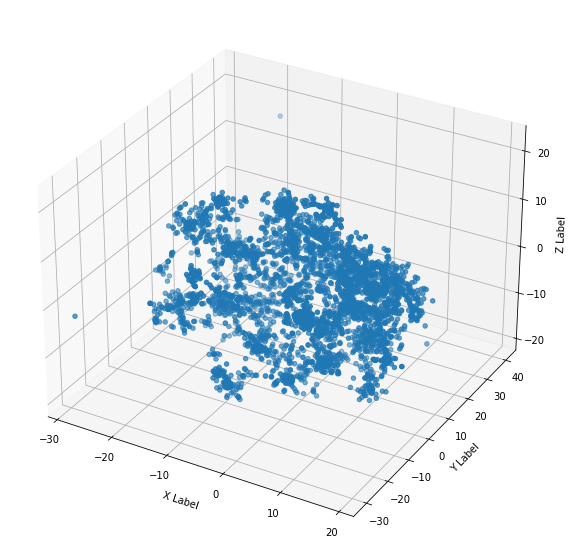

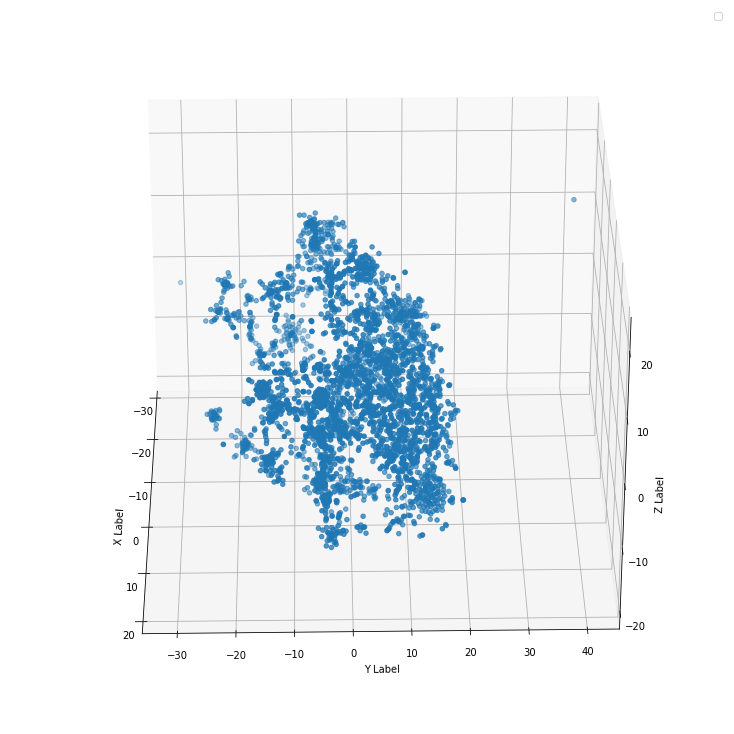

In [161]:
tsne_module = TSNE(n_components=3,n_iter=3000)

order_matrix_tsne = tsne_module.fit_transform(temp_scailing.iloc[:,1:])

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(projection='3d'
                    )

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

ax.scatter(order_matrix_tsne[:,0], 
           order_matrix_tsne[:,1], 
           order_matrix_tsne[:,2]
          )

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

fig = plt.figure(figsize = (20,10))
ax = p3.Axes3D(fig)

ax.scatter(order_matrix_tsne[:,0], 
           order_matrix_tsne[:,1], 
           order_matrix_tsne[:,2],
           #c=dbscan_result
          )
'''
for i in range(-1, np.max(dbscan_result)):
    ind_ind = np.random.choice(
                 np.where(dbscan_result == i)[0],
                 3,
                 replace = False)
    for j in ind_ind:
        ax.text(order_matrix_PCA[:,0][j], 
                        order_matrix_PCA[:,1][j], 
                        order_matrix_PCA[:,2][j],
               i,
               c = 'red')
'''
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.legend()

line_ani = animation.FuncAnimation(fig, animate, 360,
                                   interval=50, blit=False)

line_ani.save('mpl3d_tsne.gif', fps=30)

In [180]:
dbscan = DBSCAN(eps = 3.27, min_samples = 50)

dbscan_result = dbscan.fit_predict(order_matrix_tsne)

C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_3196\3730704230.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


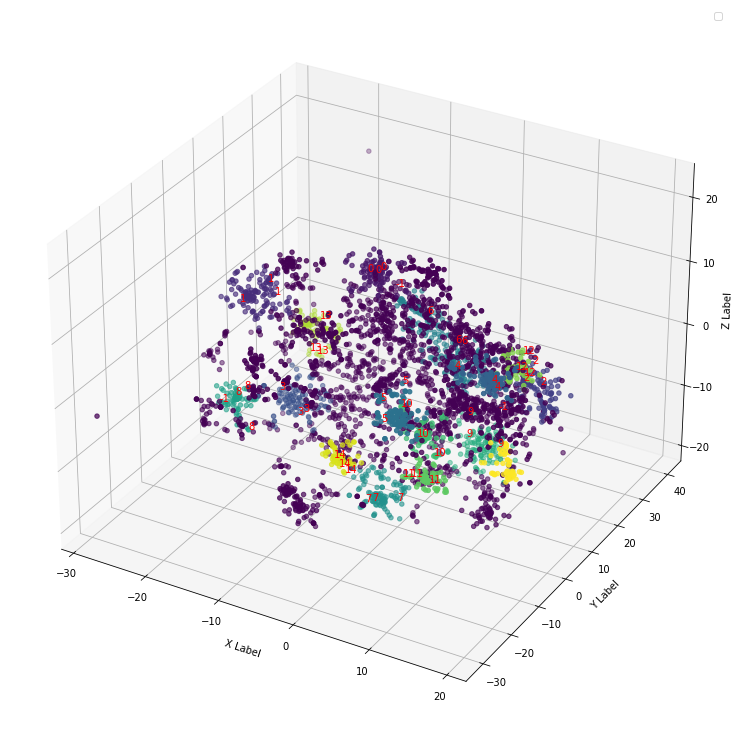

In [181]:
fig = plt.figure(figsize = (20,10))
ax = p3.Axes3D(fig)

ax.scatter(order_matrix_tsne[:,0], 
           order_matrix_tsne[:,1], 
           order_matrix_tsne[:,2],
           c=dbscan_result
          )

for i in range(-1, np.max(dbscan_result)):
    ind_ind = np.random.choice(
                 np.where(dbscan_result == i)[0],
                 3,
                 replace = False)
    for j in ind_ind:
        ax.text(order_matrix_tsne[:,0][j], 
                        order_matrix_tsne[:,1][j], 
                        order_matrix_tsne[:,2][j],
               i,
               c = 'red')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.legend()
plt.show()

In [71]:
line_ani = animation.FuncAnimation(fig, animate, 360,
                                   interval=50, blit=False)

line_ani.save('mpl3d_tsne.gif', fps=30)

MovieWriter ffmpeg unavailable; using Pillow instead.


In [70]:
# 각 클러스터별 빈도

temp_scailing_cluster = pd.concat([temp_scailing.reset_index(drop = True),
           Series(dbscan_result, name = 'cluster')], axis = 1)

temp_scailing_cluster.groupby('cluster')['buyerId'].count()

cluster
-1      363
 0     1507
 1      453
 2      187
 3      100
 4      292
 5      122
 6      201
 7      147
 8       69
 9      109
 10      59
 11      52
Name: buyerId, dtype: int64

In [72]:
for i in range(-1, max(dbscan_result)):
    cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == i].iloc[:,1:-1]

    cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
             Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
             left_index = True, right_index = True)

    print(i)
    display(cluster_neg1_power[cluster_neg1_power['power'] > 0.1])

-1


frequency     power
TOPS           179.664254  0.494943
BOTTOMS        121.702864  0.335270
OUTWEAR         95.271518  0.262456
DRESSES/SETS    70.705836  0.194782
Fashion Item    62.516395  0.172221
women's shoes   45.496152  0.125334

0


frequency     power
TOPS          1143.810347  0.758998
BOTTOMS        754.609311  0.500736
OUTWEAR        634.091323  0.420764
DRESSES/SETS   241.268547  0.160099

1


frequency     power
Dresses/Sets  208.199141  0.459601
Tops          188.961747  0.417134
Shoes/Acc     171.021477  0.377531
Bottoms       166.463610  0.367469
TOPS           49.065594  0.108313

2


frequency     power
DRESSES/SETS  182.407242  0.975440
TOPS           98.088879  0.524539
OUTWEAR        42.747233  0.228595
BOTTOMS        29.564878  0.158101

3


frequency  power
BOTTOMS       98.5  0.985

4


frequency     power
Fashion Item  250.925168  0.859333
TOPS           82.214162  0.281555
Accessories    53.483628  0.183163
BOTTOMS        46.410881  0.158941
OUTWEAR        41.908962  0.143524
Hats           34.482635  0.118091

5


frequency  power
DRESSES/SETS      122.0    1.0

6


frequency     power
TOPS      199.5  0.992537

7


frequency  power
OUTWEAR      147.0    1.0

8


frequency     power
Bag  64.633333  0.936715

9


frequency     power
women's shoes  98.572549  0.904335
SHOES          16.919444  0.155224
OUTWEAR        13.414147  0.123066

10


frequency     power
Hats     56.401662  0.955960
TOPS     21.971960  0.372406
OUTWEAR   8.322978  0.141067

In [486]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == -1].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency     power
TOPS          56.022840  0.281522
OUTWEAR       43.437087  0.218277
BOTTOMS       32.294727  0.162285
Bag           29.075783  0.146109
Fashion Item  26.548955  0.133412
DRESSES/SETS  23.794451  0.119570
jewelry etc.  23.507402  0.118128

In [487]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 0].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency     power
TOPS          1411.250484  0.641186
BOTTOMS        886.373794  0.402714
OUTWEAR        797.265053  0.362229
DRESSES/SETS   512.135155  0.232683
Fashion Item   389.822617  0.177112

In [488]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 1].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency     power
Dresses/Sets  226.521087  0.456696
Tops          198.831503  0.400870
Shoes/Acc     181.312523  0.365549
Bottoms       165.358929  0.333385
BOTTOMS        57.525596  0.115979
TOPS           55.913576  0.112729
Outwear        52.154530  0.105150

In [489]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 2].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency  power
TOPS      249.0    1.0

In [502]:
temp_scailing_cluster[temp_scailing_cluster['cluster'] == 2]

buyerId  ACCESSORY  Accessories  BEACHWEAR  BIG SIZE  BOTTOMS  Bag  \
5       8615.0        0.0          0.0        0.0       0.0      0.0  0.0   
27     16844.0        0.0          0.0        0.0       0.0      0.0  0.0   
29     16987.0        0.0          0.0        0.0       0.0      0.0  0.0   
35     17796.0        0.0          0.0        0.0       0.0      0.0  0.0   
64     19490.0        0.0          0.0        0.0       0.0      0.0  0.0   
...        ...        ...          ...        ...       ...      ...  ...   
3971  172926.0        0.0          0.0        0.0       0.0      0.0  0.0   
3992  173097.0        0.0          0.0        0.0       0.0      0.0  0.0   
3996  173114.0        0.0          0.0        0.0       0.0      0.0  0.0   
3998  173127.0        0.0          0.0        0.0       0.0      0.0  0.0   
4001  173216.0        0.0          0.0        0.0       0.0      0.0  0.0   

      Belt  Bottoms  Clutches/Wallets  ...  Tops  WOMEN  bracelets  earrings  \
5      0.0      0.0               0.0  ...   0.0    0.0        0.0       0.0   
27     0.0      0.0               0.0  ...   0.0    0.0        0.0       0.0   
29     0.0      0.0               0.0  ...   0.0    0.0        0.0       0.0   
35     0.0      0.0               0.0  ...   0.0    0.0        0.0       0.0   
64     0.0      0.0               0.0  ...   0.0    0.0        0.0       0.0   
...    ...      ...               ...  ...   ...    ...        ...       ...   
3971   0.0      0.0               0.0  ...   0.0    0.0        0.0       0.0   
3992   0.0      0.0               0.0  ...   0.0    0.0        0.0       0.0   
3996   0.0      0.0               0.0  ...   0.0    0.0        0.0       0.0   
3998   0.0      0.0               0.0  ...   0.0    0.0        0.0       0.0   
4001   0.0      0.0               0.0  ...   0.0    0.0        0.0       0.0   

      jewelry etc.  men's shoes  necklaces  rings  women's shoes  cluster  
5              0.0          0.0        0.0    0.0            0.0        2  
27             0.0          0.0        0.0    0.0            0.0        2  
29             0.0          0.0        0.0    0.0            0.0        2  
35             0.0          0.0        0.0    0.0            0.0        2  
64             0.0          0.0        0.0    0.0            0.0        2  
...            ...          ...        ...    ...            ...      ...  
3971           0.0          0.0        0.0    0.0            0.0        2  
3992           0.0          0.0        0.0    0.0            0.0        2  
3996           0.0          0.0        0.0    0.0            0.0        2  
3998           0.0          0.0        0.0    0.0            0.0        2  
4001           0.0          0.0        0.0    0.0            0.0        2  

[249 rows x 39 columns]

In [507]:
temp[temp['buyerId'] == 173216]

cat_1  buyerId  ACCESSORY  Accessories  BEACHWEAR  BIG SIZE  BOTTOMS  Bag  \
4001    173216        0.0          0.0        0.0       0.0      0.0  0.0   

cat_1  Belt  Bottoms  Clutches/Wallets  ...  TOPS  Tops  WOMEN  bracelets  \
4001    0.0      0.0               0.0  ...   1.0   0.0    0.0        0.0   

cat_1  earrings  jewelry etc.  men's shoes  necklaces  rings  women's shoes  
4001        0.0           0.0          0.0        0.0    0.0            0.0  

[1 rows x 38 columns]

In [490]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 3].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency     power
DRESSES/SETS   137.6875  0.997736

In [491]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 4].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency  power
OUTWEAR      218.0    1.0

In [492]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 5].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency     power
Hats          53.511364  0.922610
TOPS          15.375206  0.265090
DRESSES/SETS   5.926797  0.102186

In [493]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 6].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency     power
Bag  67.383333  0.962619

In [494]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 7].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency  power
BOTTOMS      129.0    1.0

In [495]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 8].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency     power
TOPS     26.000000  1.000000
BOTTOMS  17.280163  0.664622

In [496]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 9].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency     power
women's shoes      118.0  0.983333

In [497]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 10].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency     power
ACCESSORY  38.104270  0.929372
Bag         9.370292  0.228544
TOPS        6.960595  0.169771

In [498]:
cluster_neg1 = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 11].iloc[:,1:-1]

cluster_neg1_power = pd.merge(Series(cluster_neg1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_neg1.cumsum().iloc[-1,:] / cluster_neg1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_neg1_power[cluster_neg1_power['power'] > 0.1]

frequency     power
necklaces     30.129891  0.502165
earrings      28.401024  0.473350
rings         25.088746  0.418146
Fashion Item   7.319066  0.121984
bracelets      6.875368  0.114589
jewelry etc.   6.207058  0.103451

#### PCA

In [213]:
PCA_module = PCA(n_components=3)

order_matrix_PCA = PCA_module.fit_transform(temp_scailing.iloc[:,1:])

PCA_module.explained_variance_ratio_

array([0.14504719, 0.10479368, 0.09178193])

세 개의 축이 원 데이터 공간에 대해 설명하는 설명력(분산)이 세개 축 누적 46% 이다.

좋은 품질은 아니지만, 일단은 결과를 보기 위해 계속하여 진행한다.

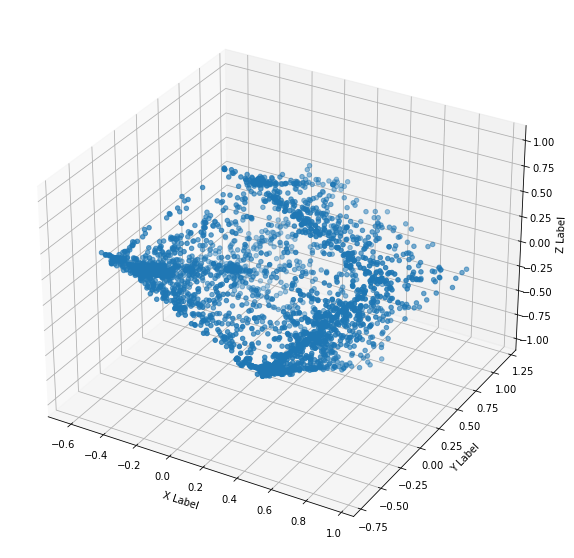

In [163]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(order_matrix_PCA[:,0], 
           order_matrix_PCA[:,1], 
           order_matrix_PCA[:,2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_3196\3917181310.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter ffmpeg unavailable; using Pillow instead.


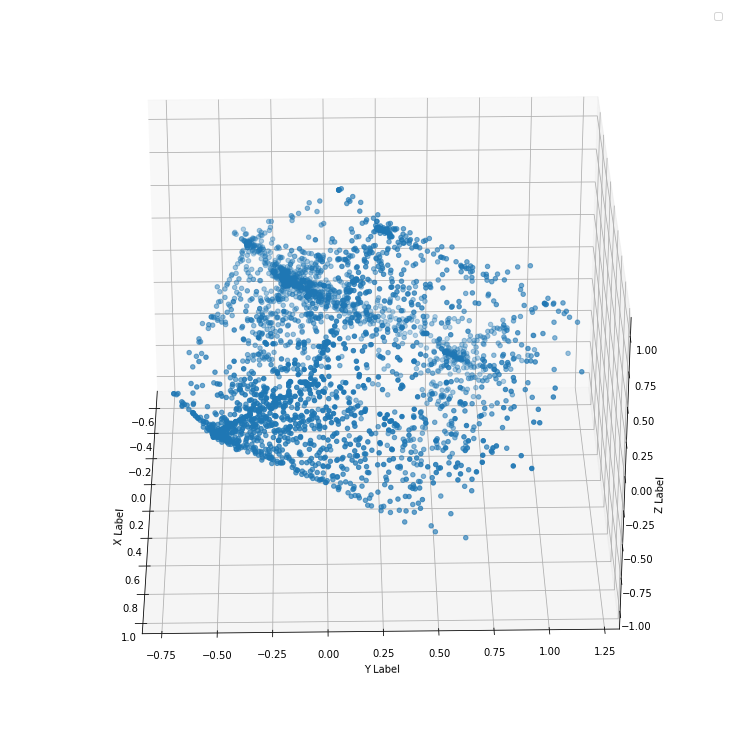

In [164]:
fig = plt.figure(figsize = (20,10))
ax = p3.Axes3D(fig)

ax.scatter(order_matrix_PCA[:,0], 
           order_matrix_PCA[:,1], 
           order_matrix_PCA[:,2],
           #c=dbscan_result
          )
'''
for i in range(-1, np.max(dbscan_result)):
    ind_ind = np.random.choice(
                 np.where(dbscan_result == i)[0],
                 3,
                 replace = False)
    for j in ind_ind:
        ax.text(order_matrix_PCA[:,0][j], 
                        order_matrix_PCA[:,1][j], 
                        order_matrix_PCA[:,2][j],
               i,
               c = 'red')
'''
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.legend()

line_ani = animation.FuncAnimation(fig, animate, 360,
                                   interval=50, blit=False)

line_ani.save('mpl3d_scatter.gif', fps=30)

In [165]:
dbscan = GaussianMixture(n_components = 10)

dbscan_result = dbscan.fit_predict(order_matrix_PCA)

C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_3196\3595930744.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


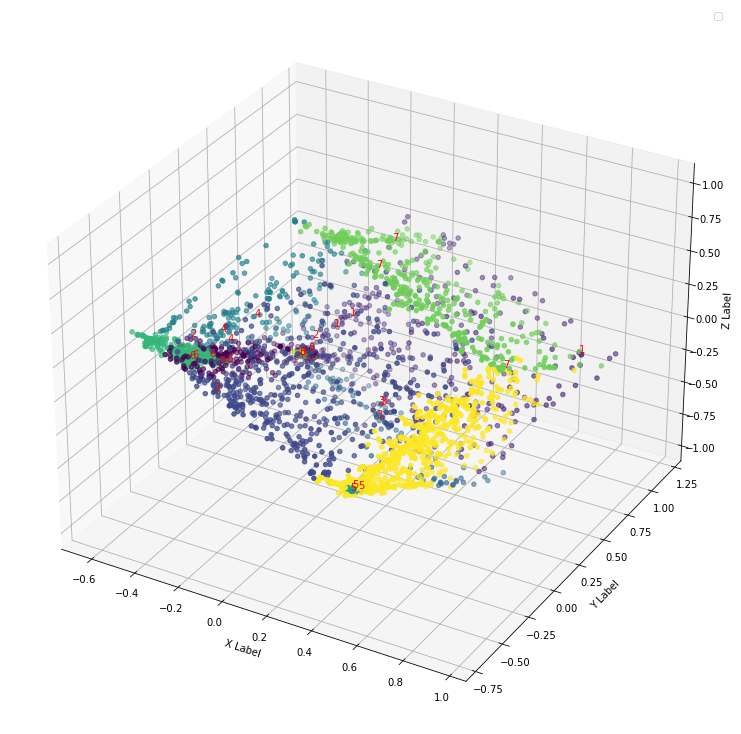

In [166]:
fig = plt.figure(figsize = (20,10))
ax = p3.Axes3D(fig)

ax.scatter(order_matrix_PCA[:,0], 
           order_matrix_PCA[:,1], 
           order_matrix_PCA[:,2],
           c=dbscan_result)

for i in range(0, np.max(dbscan_result)):
    ind_ind = np.random.choice(
                 np.where(dbscan_result == i)[0],
                 3,
                 replace = False)
    for j in ind_ind:
        ax.text(order_matrix_PCA[:,0][j], 
                        order_matrix_PCA[:,1][j], 
                        order_matrix_PCA[:,2][j],
               i,
               c = 'red')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.legend()
plt.show()

line_ani = animation.FuncAnimation(fig, animate, 360,
                                   interval=50, blit=False)


In [167]:
line_ani = animation.FuncAnimation(fig, animate, 360,
                                   interval=50, blit=False)

line_ani.save('mpl3d_dbscan.gif', fps=30)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
MovieWriter ffmpeg unavailable; using Pillow instead.


In [169]:
temp_scailing_cluster = pd.concat([temp_scailing.reset_index(drop = True),
           Series(dbscan_result, name = 'cluster')], axis = 1)

temp_scailing_cluster.groupby('cluster')['buyerId'].count()

cluster
0    257
1    290
2    462
3    104
4    180
5    160
6    922
7    481
8     98
9    651
Name: buyerId, dtype: int64

In [170]:
cluster = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 0].iloc[:,1:-1]

cluster_power = pd.merge(Series(cluster.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster.cumsum().iloc[-1,:] / cluster.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_power[cluster_power['power'] > 0.1]

frequency     power
Knitwear   115.337541  0.448784
Parkas      52.620899  0.204751
Jackets     52.139934  0.202879
Sets        49.813404  0.193826
Cardigans   38.795716  0.150956
Dresses     37.261590  0.144987
Skirts      27.499291  0.107001
Denim       26.972355  0.104951
Coats       26.666556  0.103761

In [171]:
cluster = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 1].iloc[:,1:-1]

cluster_power = pd.merge(Series(cluster.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster.cumsum().iloc[-1,:] / cluster.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_power[cluster_power['power'] > 0.1]

frequency     power
Knitwear   266.936361  0.920470
Pants      138.738228  0.478408
Tees       118.078805  0.407168
Jackets     66.673167  0.229907
Skirts      54.784471  0.188912
Cardigans   50.705436  0.174846
Dresses     48.480311  0.167173
Parkas      47.367351  0.163336
Sets        42.959309  0.148136
Denim       38.721755  0.133523
Coats       29.054129  0.100187

In [172]:
cluster = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 2].iloc[:,1:-1]

cluster_power = pd.merge(Series(cluster.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster.cumsum().iloc[-1,:] / cluster.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_power[cluster_power['power'] > 0.1]

frequency     power
Tees          229.495788  0.496744
Sets          178.801693  0.387017
Pants         104.369713  0.225908
Dresses        94.876023  0.205359
Parkas         68.126767  0.147461
Gloves/Socks   59.409725  0.128592
Accessories    53.906104  0.116680
Jackets        49.525542  0.107198
Knitwear       48.639125  0.105279

In [173]:
cluster = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 3].iloc[:,1:-1]

cluster_power = pd.merge(Series(cluster.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster.cumsum().iloc[-1,:] / cluster.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_power[cluster_power['power'] > 0.1]

frequency     power
Knitwear   93.381370  0.897898
Tees       59.569069  0.572780
Cardigans  17.100580  0.164429
Jackets    15.669705  0.150670
Skirts     14.926057  0.143520
Parkas     11.063136  0.106376

In [174]:
cluster = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 4].iloc[:,1:-1]

cluster_power = pd.merge(Series(cluster.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster.cumsum().iloc[-1,:] / cluster.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_power[cluster_power['power'] > 0.1]

frequency     power
Pants                72.939746  0.405221
Sets                 60.150386  0.334169
Dresses              26.895520  0.149420
Parkas               25.164428  0.139802
Knitwear             21.613667  0.120076
Gloves/Socks         21.316393  0.118424
Hairpin/Band/Brooch  20.271606  0.112620
Jackets              18.693177  0.103851

In [175]:
cluster = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 5].iloc[:,1:-1]

cluster_power = pd.merge(Series(cluster.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster.cumsum().iloc[-1,:] / cluster.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_power[cluster_power['power'] > 0.1]

frequency  power
Tees      160.0    1.0

In [86]:
cluster = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 6].iloc[:,1:-1]

cluster_power = pd.merge(Series(cluster.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster.cumsum().iloc[-1,:] / cluster.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_power[cluster_power['power'] > 0.1]

frequency     power
Dresses/Sets   118.003074  0.203805
Fashion Item   111.923452  0.193305
Tops           102.390218  0.176840
Bottoms         86.750915  0.149829
Shoes/Acc       86.051806  0.148621
women's shoes   58.350155  0.100777

In [87]:
cluster = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 7].iloc[:,1:-1]

cluster_power = pd.merge(Series(cluster.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster.cumsum().iloc[-1,:] / cluster.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_power[cluster_power['power'] > 0.1]

frequency     power
TOPS          122.791667  0.998306
DRESSES/SETS   22.869318  0.185929
Fashion Item   22.554420  0.183369
BOTTOMS        17.425786  0.141673

In [88]:
cluster = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 8].iloc[:,1:-1]

cluster_power = pd.merge(Series(cluster.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster.cumsum().iloc[-1,:] / cluster.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_power[cluster_power['power'] > 0.1]

frequency     power
BOTTOMS        277.457274  0.678380
TOPS           166.487454  0.407060
DRESSES/SETS   128.507291  0.314199
Fashion Item    99.644814  0.243630
OUTWEAR         97.742202  0.238978
Shoes/Acc       46.900389  0.114671
Tops            45.573585  0.111427
Dresses/Sets    44.954856  0.109914
women's shoes   41.964907  0.102604

In [89]:
cluster = temp_scailing_cluster[temp_scailing_cluster['cluster'] == 9].iloc[:,1:-1]

cluster_power = pd.merge(Series(cluster.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster.cumsum().iloc[-1,:] / cluster.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_power[cluster_power['power'] > 0.1]

frequency  power
OUTWEAR      148.0    1.0

#### - 잠재 디리클레 할당 Topic Modeling

잠재 디리클레 할당(Latent DIrichlet Allocation)은 자연어처리(NLP)에서 주로 사용되는 알고리즘으로, 

- 가상의 주제(TOPIC)을 설정하고, 
- 문서에 등장하는 모든 단어들을 LDA 알고리즘이 각 TOPIC으로 자동으로 할당하여
- 각 TOPIC별로 할당된 단어와, 이에 기반하여 마찬가지로 할당된 문서의 분포 양상을 보고 인사이트를 얻는 방법론이다.

가령, 분석가가 TOPIC을 5개로 추정하고, LDA를 이용해 5개 문서에 대한 LDA를 수행하면
TOPIC1에 'Women, Tops, Outware'라는 단어가 할당되었다면 TOPIC1을 '여성복'에 대한 TOPIC으로
TOPIC2에 'Kids, Dresses/Sets, KidsHats'가 할당되었다면 '아동복'에 대한 TOPIC으로 추정하여
각 TOPIC별로 어떤 문서들이 할당되었는지를 마찬가지로 판단할 수 있게 된다.

아래 분석에서는, 문서를 '각 고객'으로, 단어를 '상품 카테고리'로 치환하여 LDA를 수행한다. 즉

- 7549명 고객 데이터 : 문서

- 106개 상품 카테고리 : 단어

In [162]:
temp_cat0_scailing = temp_cat0.apply(lambda x : min_max_scailing(x, 'buyerId'), axis = 1)

temp_cat0_scailing = pd.concat(temp_cat0_scailing.values)

In [163]:
temp_cat1_scailing = temp_cat1.apply(lambda x : min_max_scailing(x, 'buyerId'), axis = 1)

temp_cat1_scailing = pd.concat(temp_cat1_scailing.values)

In [164]:
temp_cat2_scailing = temp_cat2.apply(lambda x : min_max_scailing(x, 'buyerId'), axis = 1)

temp_cat2_scailing = pd.concat(temp_cat2_scailing.values)

In [170]:
perplexity = list()

for i in range(2,20):
    lda = LatentDirichletAllocation(n_components=i, random_state=42)
    lda.fit(temp_cat0_scailing.iloc[:,1:])
    perplexity.append(lda.perplexity(temp_cat0_scailing.iloc[:,1:]))


In [172]:
DataFrame({'topic_num' : [i for i in range(2,20)],
           'perplexity' : perplexity})


topic_num  perplexity
0           2    6.300514
1           3    7.332908
2           4    8.662388
3           5   12.066949
4           6   12.045782
5           7   16.503695
6           8   16.019084
7           9   17.758065
8          10   19.131344
9          11   20.536305
10         12   22.760183
11         13   24.120300
12         14   25.050067
13         15   27.105137
14         16   35.362939
15         17   30.891119
16         18   31.044633
17         19   32.808627

In [175]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(temp_cat0_scailing.iloc[:,1:])

doc_topic = lda.transform(temp_cat0_scailing.iloc[:,1:])

In [176]:
def user_user_factorization(df, ind, csm, k, verbose = False):
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n",
            pd.unique(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]]['prodName']), "\n")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',"\n",
                 pd.unique(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]]['prodName']),"\n")
    return np.sort(csm[ind])[-k:-1]

In [177]:
cluster_topic = \
pd.concat([temp_cat0['buyerId'].reset_index(drop = True),
           Series(np.argmax(doc_topic, axis = 1), name = 'cluster'),
           Series(np.max(doc_topic, axis = 1), name = 'value')],
         axis = 1)

In [178]:
test = pd.merge(temp_cat2_scailing,
         cluster_topic.loc[cluster_topic['cluster'] == \
                int(cluster_topic.loc[cluster_topic['buyerId'] == buyer_id,'cluster'])]['buyerId'],
         on = 'buyerId')

u,s,v = np.linalg.svd(test.iloc[:,1:].to_numpy(), full_matrices = False)

#특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.

energy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))

#위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.
print(energy_where)
order_matrix_reconstruct = np.dot(u[:,0:energy_where], np.dot(np.diag(s[0:energy_where]), v[0:energy_where]))
csm_cluster = cosine_similarity(order_matrix_reconstruct)

41


- LDA -> CSM과 전체 CSM 사이에서 품질 차이가 있는지 양쪽을 왔다갔다하며 확인한다

In [475]:
test = pd.merge(temp_cat2_scailing,
         cluster_topic.loc[cluster_topic['cluster'] == 0, 'buyerId'],
        on = 'buyerId')

In [478]:
cosine_similarity(test.iloc[:,1:])

array([[1.        , 0.        , 0.59016711, ..., 1.        , 0.9486833 ,
        0.95677377],
       [0.        , 1.        , 0.12765033, ..., 0.        , 0.        ,
        0.08821242],
       [0.59016711, 0.12765033, 1.        , ..., 0.59016711, 0.79627616,
        0.56465641],
       ...,
       [1.        , 0.        , 0.59016711, ..., 1.        , 0.9486833 ,
        0.95677377],
       [0.9486833 , 0.        , 0.79627616, ..., 0.9486833 , 1.        ,
        0.9076753 ],
       [0.95677377, 0.08821242, 0.56465641, ..., 0.95677377, 0.9076753 ,
        1.        ]])

In [242]:
def user_user_factorization_model(df_depth1, df_depth2, topic_num, top_k = 2, verbose = False):
    if verbose:
        print(topic_num)
    model = LatentDirichletAllocation(n_components=topic_num, random_state=42)
    model.fit(df_depth1.iloc[:,1:])

    doc_topic = model.transform(df_depth1.iloc[:,1:])

    cluster_topic = \
    pd.concat([df_depth1['buyerId'].reset_index(drop = True),
               Series(np.argmax(doc_topic, axis = 1), name = 'cluster'),
               Series(np.max(doc_topic, axis = 1), name = 'value')],
             axis = 1)
    csm_score_total = list()
    csm_list = dict()
    for k in range(topic_num):
        test = pd.merge(df_depth2,
                        cluster_topic.loc[cluster_topic['cluster'] == k
                                          ,'buyerId'],
                         on = 'buyerId')
        u,s,v = np.linalg.svd(test.iloc[:,1:].to_numpy(), full_matrices = False)
        if verbose:
            print(s.astype(int))
        energy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))
        order_matrix_reconstruct = np.dot(u[:,0:energy_where], 
                                          np.dot(np.diag(s[0:energy_where]), 
                                                         v[0:energy_where]))
        csm_cluster = cosine_similarity(order_matrix_reconstruct)
        csm_list.update({k : csm_cluster})
        csm_score = list()
        for buyer_id in test['buyerId']:
            csm_score.append(
                np.mean(
                        user_user_factorization(test, 
                                   int(test[test['buyerId'] == buyer_id].index.values),
                                      csm_cluster,
                                      top_k,
                                      #verbose = verbose
                                               )
                        )
            )
        csm_score_total.append(np.mean(csm_score))
    return csm_score_total, csm_list, cluster_topic

In [247]:
a = \
[np.mean(user_user_factorization_model(temp_cat0_scailing,
                             temp_cat2_scailing,
                             i, verbose = True)[0]) for i in range(1,12)]

1
[45 23 21 21 16 15 14 14 12 11 11 10 10 10  9  9  8  8  8  7  7  7  7  6
  6  6  5  5  5  5  5  5  4  4  4  4  4  4  4  4  3  3  3  3  3  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  0  0  0  0  0  0  0  0
  0  0  0  0  0]
2
[36 19 17 16 14 13 11 11 10  9  9  8  6  6  5  5  5  4  4  4  4  4  3  3
  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1
  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
[27 14 13 13 11 10  9  9  7  7  7  7  7  6  6  6  5  5  5  5  5  4  4  4
  4  4  4  4  4  4  4  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
3
[37 19 17 16 14 13 12 11 10  9  9  8  6  6  5  5  5  5  4  4  4  4  4  3
  3  3  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
[13  9  7  7  6  6  6  6  5  5  5  4  4  4  4  4  

[1 0 0]
[19 10  9  7  6  4  4  4  3  3  2  2  2  2  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
10
[10  4  3  3  2  2  2  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
[2 2 1 1 1 0 0 0 0 0 0 0 0 0 0]
[6 4 3 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[12  8  6  6  5  4  4  4  3  3  3  3  3  3  3  3  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
[17 10  8  7  6  4  4  3  3  2  2  2  2  1  1  1  1  1  1  1  1  1  1  0
  0  0  0  0  0  0

In [250]:
csm = user_user_factorization_model(temp_cat0_scailing,
                             temp_cat2_scailing,
                             10,
                                   verbose = True)

10
[10  4  3  3  2  2  2  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
[2 2 1 1 1 0 0 0 0 0 0 0 0 0 0]
[6 4 3 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[12  8  6  6  5  4  4  4  3  3  3  3  3  3  3  3  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
[17 10  8  7  6  4  4  3  3  2  2  2  2  1  1  1  1  1  1  1  1  1  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
[3 2 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[6 3 3 2 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 

In [266]:
csm[1][0]

array([[1.        , 0.52681385, 0.55328876, ..., 0.73080182, 0.26049894,
        0.61036987],
       [0.52681385, 1.        , 0.68341975, ..., 0.78825002, 0.68820759,
        0.13880849],
       [0.55328876, 0.68341975, 1.        , ..., 0.66977855, 0.41423084,
        0.2391542 ],
       ...,
       [0.73080182, 0.78825002, 0.66977855, ..., 1.        , 0.33508883,
        0.09566846],
       [0.26049894, 0.68820759, 0.41423084, ..., 0.33508883, 1.        ,
        0.27293274],
       [0.61036987, 0.13880849, 0.2391542 , ..., 0.09566846, 0.27293274,
        1.        ]])

In [351]:
def user_user_factorization(df, ind, csm, k, verbose = False):
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
        display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][['productId',
                                                                                              'prodName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',"\n")
            display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][[
                                                                                              'productId',
                                                                                              'prodName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
    return np.sort(csm[ind])[-k:-1]

In [277]:
cluster = 0

In [281]:
csm[2][csm[2]['cluster'] == 0]

buyerId  cluster     value
1       1234.0        0  0.596717
11     11057.0        0  0.666829
51     18821.0        0  0.639432
69     19750.0        0  0.725609
108    22118.0        0  0.629635
...        ...      ...       ...
3461  171247.0        0  0.622533
3505  171491.0        0  0.634326
3702  172850.0        0  0.658753
3757  173109.0        0  0.629364
3776  173274.0        0  0.682288

[98 rows x 3 columns]

In [372]:
cluster = 9

In [376]:
user_user_factorization(pd.merge(temp_cat2_scailing,
                                 csm[2][csm[2]['cluster'] == cluster]['buyerId'],
                                 on = 'buyerId'),
                        1998,
                        csm[1][cluster],
                        10,
                       verbose = True)

<1. cosine similarity>
userID : 76534.0 -  0.9239103931473167
userID : 143984.0 -  0.9206164330643235
userID : 170968.0 -  0.9102918178735037
userID : 24659.0 -  0.9043913756175969
userID : 172955.0 -  0.8999916371686281
userID : 80446.0 -  0.8944208323342397
userID : 101746.0 -  0.8944174388825842
userID : 117718.0 -  0.8944174388825842
userID : 131091.0 -  0.8888973372181846


<2. Top - K user's Category list>
target - 172607.0 {'Skirts', 'Knitwear', 'Tees'}
UserID - 76534.0 {'Skirts', 'Cardigans', 'Parkas', 'Knitwear'}
UserID - 143984.0 {'Jackets', 'Parkas', 'Tees', 'Pants', 'Dresses', 'Leggings', 'Skirts', 'Hairpin/Band/Brooch', 'Cardigans', 'Knitwear', 'Knit Dresses/Sets'}
UserID - 170968.0 {'Skirts', 'Jackets', 'Tees', 'Knitwear'}
UserID - 24659.0 {'Denim', 'Coats', 'Tees', 'Dresses', 'flip flops & slides', 'Skirts', 'Knitwear'}
UserID - 172955.0 {'Skirts', 'Cardigans', 'Tees', 'Pants', 'Knitwear'}
UserID - 80446.0 {'Skirts', 'Knitwear'}
UserID - 101746.0 {'Skirts', 'Knitwear'}
U

productId    prodName  cat_0    cat_1     cat_2
143245   7162497  시카고 자수 맨투맨    MEN     TOPS      Tees
206837   7161751   링1)토모브이NT  WOMEN     TOPS  Knitwear
206843   7152428    링1)로진훌sk  WOMEN  BOTTOMS    Skirts

UserID - 76534.0 



productId                           prodName  cat_0    cat_1      cat_2
30829    7113091                             에이드가디건  WOMEN  OUTWEAR  Cardigans
81633    6285322                        인기재진행)유자폴라티  WOMEN     TOPS   Knitwear
123882   7088342  [New] 유유SL (겨울 신상 체크 치마 바지 숏 스커트)  WOMEN  BOTTOMS     Skirts
136996   7099860                             베니스무스탕  WOMEN  OUTWEAR     Parkas
231771   7102675                              피넛울sk  WOMEN  BOTTOMS     Skirts
248647   6978841                                리플r  WOMEN     TOPS   Knitwear

UserID - 143984.0 



productId                                   prodName      cat_0  \
251      7019888                               골지니트 티 신상 반목      WOMEN   
1699     1541226                        미샤 #sk #대박상품 #심플♥ㅡㅡ      WOMEN   
1814     6386922                                    사선단추가디건      WOMEN   
1931     6926815                             H181 체인 헤어 집게핀  ACCESSORY   
3118     6966036                              H140 꽃 헤어 집게핀  ACCESSORY   
3187     7090042                                   하임떡볶이가디건      WOMEN   
3611     7076586                                 울꽈배기 니트스커트      WOMEN   
7964     6992991                                  세일 단추카라니트      WOMEN   
8054     7032591                                    집업후드원피스      WOMEN   
23575    7097663   특기모)밴딩와이드.pt 와이드팬츠.기모팬츠.밴딩.두툼기모.넉넉한핏.데일리      WOMEN   
25785    7002856                            큐티알티-가을신상,단추가디건      WOMEN   
47417    7064674                                니트가디건스커트 세트      WOMEN   
62446    6993627                             sale23#) 랩 가디건      WOMEN   
98515    7076890                                  플라워후리스아노락       KIDS   
114153   7094883                                     트리안울니트      WOMEN   
116233   7082375                                        비너스      WOMEN   
116268   7092374        진주단추가디건 (니트 가디건 레이어드 겨울니트 겨울가디건 도톰)      WOMEN   
123872   7026589        와플H(체크스커트,H스커트,슬릿스커트,단추스커트,미니체크스커트)      WOMEN   
124013   7088357      [New] 쌈디SK (겨울 신상 미니 무지 핀턱 주름 치마 스커트)      WOMEN   
131765   7118670                슬림후드ops)후드원피스 특기모 양기모 겨울 신상      WOMEN   
189974   7107682                                  솜사탕 니트가디건      WOMEN   
217554   3301807  y존커버 시크릿 속바지 (#4계절 #신상 #데일리 #베이직 #두겹 #밴딩)      WOMEN   
217741   7098667                                 단추양털뽀글이후리스      WOMEN   
262239   7097417                                     로즈후리스       WOMEN   

               cat_1                cat_2  
251             TOPS             Knitwear  
1699         BOTTOMS               Skirts  
1814            TOPS             Knitwear  
1931    Fashion Item  Hairpin/Band/Brooch  
3118    Fashion Item  Hairpin/Band/Brooch  
3187         OUTWEAR            Cardigans  
3611         BOTTOMS               Skirts  
7964            TOPS             Knitwear  
8054    DRESSES/SETS              Dresses  
23575        BOTTOMS                Pants  
25785           TOPS             Knitwear  
47417   DRESSES/SETS    Knit Dresses/Sets  
62446           TOPS             Knitwear  
98515           Tops                 Tees  
114153          TOPS             Knitwear  
116233       BOTTOMS               Skirts  
116268          TOPS             Knitwear  
123872       BOTTOMS               Skirts  
124013       BOTTOMS               Skirts  
131765  DRESSES/SETS              Dresses  
189974          TOPS             Knitwear  
217554       BOTTOMS             Leggings  
217741       OUTWEAR               Parkas  
262239       OUTWEAR              Jackets

UserID - 170968.0 



productId                            prodName  cat_0    cat_1     cat_2
23795    7097660  특기모)카라크롭mtm 크롭맨투맨.반집업.아방핏.데일리.두툼기모  WOMEN     TOPS      Tees
34069    7013338                       몬스터 자켓# 신상 자켓  WOMEN  OUTWEAR   Jackets
39917    7098695                   4c 레이핏 크롭 니트탑(도톰)  WOMEN     TOPS  Knitwear
106228   6999594                      (세일)보카 라운드넥 니트  WOMEN     TOPS  Knitwear
123906   7117187    [New] 커튼콜 (겨울 신상 무지 스커트 롱 니트 치마)  WOMEN  BOTTOMS    Skirts
129308   7033398                      sale2023#)레토니트  WOMEN     TOPS  Knitwear
239843   5374852               sale 2023#)909밴드치마 세일  WOMEN  BOTTOMS    Skirts

UserID - 24659.0 



productId                               prodName  cat_0          cat_1  \
110      5331978                셀린SK(신상,니트스커트,가을,골지스커트)  WOMEN        BOTTOMS   
7448     7036063                                  앤클랏코트  WOMEN        OUTWEAR   
68052    7017307                                  루앙가디건  WOMEN           TOPS   
68115    7132150                                 몰리골덴sk  WOMEN        BOTTOMS   
69360    7050619                                 제니 원피스  WOMEN   DRESSES/SETS   
106674   7067587                  6000번 레직기주름 워싱 부츠컷 데님  WOMEN        BOTTOMS   
217181   6633503  세일 ) SD-0192 크란 스퀘어 기본 스티치 데일리 구두 힐 뮬  SHOES  women's shoes   
264266   6336872                            단가라 폴라 티셔츠   WOMEN           TOPS   

                      cat_2  
110                  Skirts  
7448                  Coats  
68052              Knitwear  
68115                Skirts  
69360               Dresses  
106674                Denim  
217181  flip flops & slides  
264266                 Tees

UserID - 172955.0 



productId                       prodName  cat_0    cat_1      cat_2
3410     6920121                         반목반팔니트  WOMEN     TOPS   Knitwear
65388    7177589                  캐5260 하이카라니트탑  WOMEN     TOPS       Tees
68832    6378681                     신상 울니트 가디건  WOMEN  OUTWEAR  Cardigans
69092    7113967                        언발브이넥티   WOMEN     TOPS   Knitwear
242555   7154775  뱀부로제라운드니트#신상 대나무실 기본 데일리  베이직  WOMEN     TOPS   Knitwear
247301   7179665                          주리 니트  WOMEN     TOPS   Knitwear
249887   7158447                 리퍼팬츠 #슬랙스 #봄신상  WOMEN  BOTTOMS      Pants
252627   6846545                          맥시롱sk  WOMEN  BOTTOMS     Skirts

UserID - 80446.0 



productId          prodName  cat_0    cat_1     cat_2
144367   6998832      주문폭주 투웨이니트집업  WOMEN     TOPS  Knitwear
196210   7045521  빅히트) 랑빙 니트 밴딩스커트  WOMEN  BOTTOMS    Skirts

UserID - 101746.0 



productId                           prodName  cat_0    cat_1     cat_2
123940   7117191  [New] 주희SL (신상 미니 스커트 치마 무지 치마바지)  WOMEN  BOTTOMS    Skirts
215000   6996218                메디치 울 자가드 가디건 자켓 세일  WOMEN     TOPS  Knitwear
222060   6392917                           울체크미니스커트  WOMEN  BOTTOMS    Skirts

UserID - 117718.0 



productId        prodName  cat_0    cat_1     cat_2
253878   6350540    홀가먼트- 케이블라운드  WOMEN     TOPS  Knitwear
253880   6350542  홀가먼트- 케이블니트스커트  WOMEN  BOTTOMS    Skirts
253882   6213111   홀가먼트- 플레어롱스커트  WOMEN  BOTTOMS    Skirts

UserID - 131091.0 



productId                        prodName  cat_0    cat_1      cat_2
30830    7044530                            버터VT  WOMEN     TOPS   Knitwear
34343    5218276                       아가일브이체크니트  WOMEN     TOPS   Knitwear
132137   7033446  SK-529 코듀로이 2단 캉캉이 후레아 플레어 스커트  WOMEN  BOTTOMS     Skirts
211502   6995927                         단추브이가디건  WOMEN  OUTWEAR  Cardigans

array([0.88889734, 0.89441744, 0.89441744, 0.89442083, 0.89999164,
       0.90439138, 0.91029182, 0.92061643, 0.92391039])

In [468]:
def cross_validation(self, **param):

    objective = objective_func(self.test_set[self.time:, self.num], y_pred)

    return 1 / objective

In [ ]:
model_dict = dict()
self.param_dict = dict()
self.test_set = X_test.copy()

self.num = i
self.train_set = lgb.Dataset(X_train[:-self.time], X_train[self.time:,self.num])
self.val_set = lgb.Dataset(X_test[:-self.time], X_test[self.time:,self.num])
bo = BayesianOptimization(f = self.cross_validation,
                          pbounds = self.params,
                          verbose = 0,
                          random_state = 0)
bo.maximize(init_points=2, n_iter=200, acq='ei')
max_param = bo.max['params']
max_param.update({'verbose' : -1})
model = lgb.train(max_param,
                  self.train_set,
                  valid_sets=self.val_set)

model_dict.update({i : model})
self.param_dict.update({i : max_param})

In [467]:
np.mean(user_user_factorization(test, 
                        int(test[test['buyerId'] == buyer_id].index.values), 
                        csm_cluster, 10))

<1. cosine similarity>
userID : 104761.0 -  0.8948775896566739
userID : 124106.0 -  0.8839649695300114
userID : 171247.0 -  0.8705739207993566
userID : 130316.0 -  0.8701240673427256
userID : 118000.0 -  0.846912285970711
userID : 169669.0 -  0.8288307853682202
userID : 166922.0 -  0.8171021016665435
userID : 168196.0 -  0.8138988655685191
userID : 150085.0 -  0.805340363120064


<2. Top - K user's Category list>
target - 18947.0 {'Tees', 'Dresses', 'Sets', 'Coats'}
UserID - 104761.0 {'Tees', 'Dresses', 'Skirts', 'Sets', 'Coats', 'Denim'}
UserID - 124106.0 {'Tees', 'Dresses', 'Cardigans', 'Knitwear', 'Sets', 'flip flops & slides'}
UserID - 171247.0 {'Tees', 'Dresses', 'Pants', 'Sets'}
UserID - 130316.0 {'Tees', 'Dresses', 'Skirts', 'Sets'}
UserID - 118000.0 {'Pants', 'Cardigans', 'Knitwear', 'Boots', 'Jackets', 'Tees', 'Dresses', 'Sets'}
UserID - 169669.0 {'Blouses', 'Tees', 'Knit Dresses/Sets', 'Sets'}
UserID - 166922.0 {'SHOES&ACC', 'Pants', 'Jackets', 'Others', 'Tees', 'Dresses', 'S

0.8479583276692026

In [285]:
np.argsort(csm, axis = 1)

array([[ 3, 31, 13, ..., 18, 57,  0],
       [33, 25, 39, ..., 34, 26,  1],
       [15, 23, 59, ..., 42,  2, 44],
       ...,
       [ 7, 23, 15, ..., 27,  0, 57],
       [ 0, 20, 33, ...,  4, 53, 58],
       [42, 44,  2, ..., 49, 28, 59]], dtype=int64)

In [267]:
cos = cosine_similarity(test)

- LDA로 1차 클러스터를 묶음
- 1차 클러스터 내에서 코사인 유사도 비교 -> **계층적 클러스터링!!!!**

In [217]:
for i in range(0,12):
    topic_num = i

    topic_values = Series(lda.components_[topic_num]).sort_values(ascending = False).reset_index(drop = True)

    topic_0 = pd.concat([Series(temp_cat1.iloc[:,1:].columns[lda.components_[topic_num].argsort()[::-1]]),
              topic_values,
              topic_values.cumsum() / topic_values.sum()
              ], axis = 1)

    topic_0.columns = ['category', 'Dirichlet Var Param', 'cumsum']

    print(i)
    display(topic_0[topic_0['cumsum'] < 0.91])

0


category  Dirichlet Var Param    cumsum
0           Eye wear             6.385969  0.392221
1               Tops             2.123622  0.522653
2            OUTWEAR             1.930750  0.641238
3          Shoes/Acc             1.666270  0.743579
4            BOTTOMS             1.217580  0.818362
5            Bottoms             0.345394  0.839575
6       Dresses/Sets             0.107711  0.846191
7       DRESSES/SETS             0.084946  0.851408
8               TOPS             0.084755  0.856614
9            Outwear             0.084452  0.861801
10               Bag             0.083371  0.866921
11     women's shoes             0.083358  0.872041
12    DRESSES & SETS             0.083342  0.877160
13          BIG SIZE             0.083338  0.882278
14  Clutches/Wallets             0.083338  0.887397
15              Hats             0.083337  0.892516
16         bracelets             0.083337  0.897634
17         ACCESSORY             0.083337  0.902752
18       men's shoes             0.083336  0.907871

1


category  Dirichlet Var Param    cumsum
0      jewelry etc.            43.214272  0.692772
1  Clutches/Wallets            11.734320  0.880886

2


category  Dirichlet Var Param    cumsum
0  DRESSES/SETS           432.116602  0.605861
1          TOPS            84.750992  0.724688
2     ACCESSORY            46.919101  0.790473
3       OUTWEAR            39.708153  0.846146
4      BIG SIZE            25.586265  0.882020

3


category  Dirichlet Var Param    cumsum
0  OUTWEAR           596.973920  0.531581
1     TOPS           213.991821  0.722132
2  BOTTOMS           129.827860  0.837739

4


category  Dirichlet Var Param    cumsum
0       BOTTOMS           723.612532  0.465436
1          TOPS           422.739940  0.737347
2       OUTWEAR           176.903611  0.851134
3  DRESSES/SETS            80.793838  0.903101

5


category  Dirichlet Var Param    cumsum
0   Fashion Item           335.345995  0.465563
1    Accessories            90.044228  0.590573
2           Hats            62.882886  0.677873
3           TOPS            57.906472  0.758265
4        OUTWEAR            35.968633  0.808201
5        BOTTOMS            35.794645  0.857895
6  women's shoes            22.944985  0.889750

6


category  Dirichlet Var Param    cumsum
0     TOPS          1036.535747  0.651815
1  BOTTOMS           181.634894  0.766034
2  OUTWEAR           168.074263  0.871726

7


category  Dirichlet Var Param    cumsum
0  women's shoes           157.119248  0.540984
1   Dresses/Sets            76.614898  0.804781

8


category  Dirichlet Var Param    cumsum
0      Bag           135.210216  0.860637

9


category  Dirichlet Var Param    cumsum
0          Tops           227.957582  0.301294
1       Bottoms           193.710432  0.557323
2  Dresses/Sets           144.685390  0.748555
3     Shoes/Acc            69.628894  0.840584

10


category  Dirichlet Var Param    cumsum
0     Shoes/Acc           153.083856  0.453745
1          Hats            76.259887  0.679782
2  Dresses/Sets            48.434726  0.823344
3          KIDS            21.353890  0.886638

11


category  Dirichlet Var Param    cumsum
0   earrings            62.515131  0.313314
1      rings            45.437802  0.541040
2  necklaces            42.206678  0.752572
3  BEACHWEAR            14.131022  0.823394
4  bracelets            13.681836  0.891965

**패턴이 매우 뚜렷하게 나온것은 아니나, 대략 세트 구매 / 상의 / 하의 / 외투 / 아동복 / 악세서리로 구분되는 것으로 보인다.**

#### - 차원축소 없이 K-Means

차원축소(PCA) 후 DBSCAN을 사용하는 것은, 분석가가 직접 눈으로 확인하면서 유의미한 클러스터를 직접 도출 가능하는 점에서 장점이 있다.

그러나, 차원축소(PCA) 과정에서 설명력(분산)의 59%를 손실해버렸다. 다시 말해, 유의미한 정보를 담았을 수도 있는 축이 인간이 3차원까지만 인식 가능하다는 한계때문에 유실된 것이다.

**시각화 하기 위해 차원축소를 하지 않고, 고차원(107차원)의 데이터셋에 대하여 직접 K-Means를 실시한다.**

In [86]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in range(1, 20):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=42)
        km.fit(data)
        distortions.append(km.inertia_)
    return distortions

In [87]:
elbows = visualize_elbowmethod(temp_cat2_scailing.iloc[:,1:])

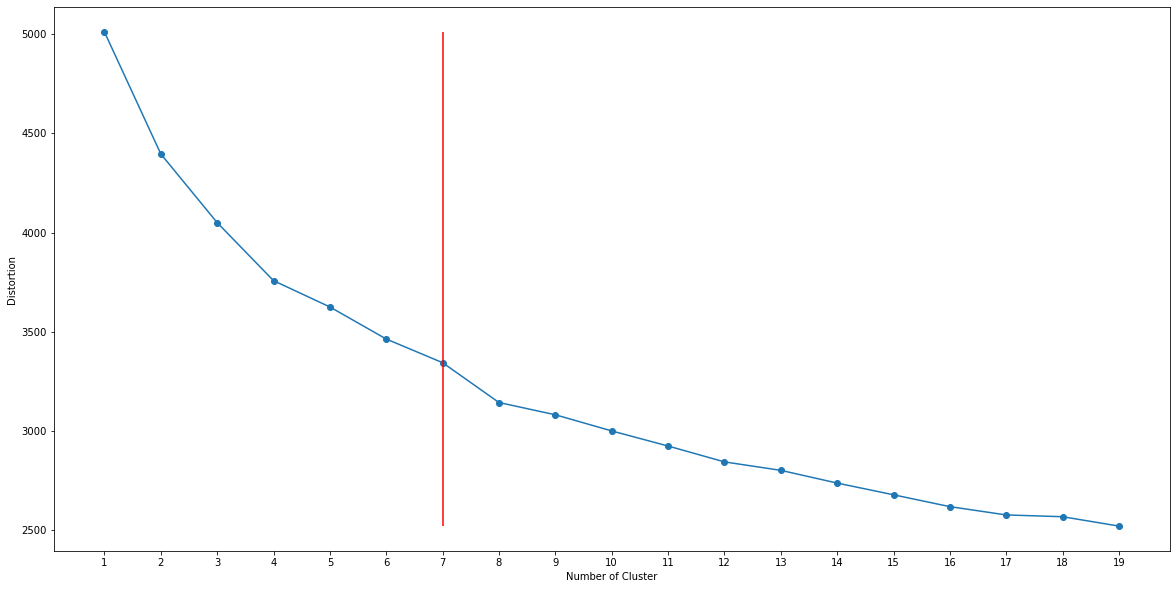

In [88]:
plt.figure(figsize = (20,10))
plt.plot(range(1, 20), elbows, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.xticks(range(0,20))
plt.vlines(7, ymin = min(elbows), ymax = max(elbows), color = 'red')
plt.show()

In [90]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X.iloc[labels == i], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

kmeans = [KMeans(n_clusters = i).fit(temp_cat2_scailing.iloc[:,1:]) for i in range(1,20)]

bic = [compute_bic(kmeansi, temp_cat2_scailing.iloc[:,1:]) for kmeansi in kmeans]

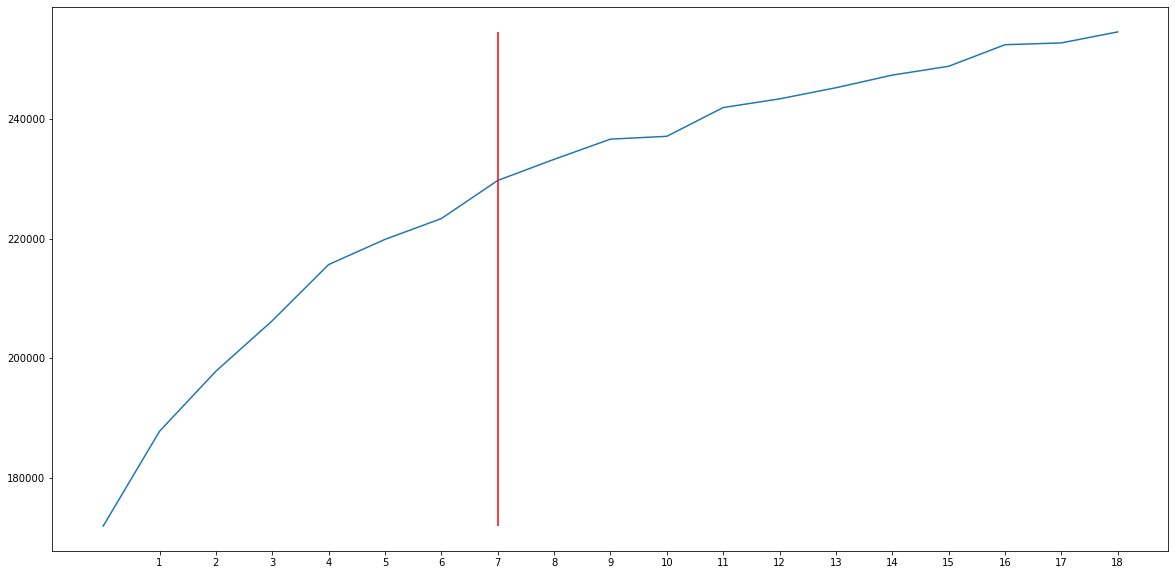

In [91]:
plt.figure(figsize = (20,10))
plt.plot(bic)
plt.xticks(range(1,20))
plt.vlines(7, ymin = min(bic), ymax = max(bic), color = 'red')
plt.show()

각 클러스터의 집단내 분산의 합을 이용하는 Elbow 기법을 활용했을 때, 꺾이는 부분이 딱히 존재하진 않다.

BIC Method를 이용해도 줄어드는 지점은 보이지 않는다.

다만, **기울기**가 줄어드는 지점은 다섯번째 점, 즉 클러스터 갯수 6개일때로 보인다.


In [92]:
kmeans = KMeans(n_clusters = 7)

In [95]:
cluster = kmeans.fit_predict(temp_cat2_scailing.iloc[:,1:])

In [96]:
#각 클러스터별 갯수
Series(cluster).value_counts()

0    892
1    878
2    579
4    530
6    379
5    247
3    206
dtype: int64

In [203]:
temp_scailing_cluster = temp_scailing.copy()

In [204]:
temp_scailing_cluster['cluster_kmeans'] = cluster

In [205]:
cluster_0 = temp_scailing_cluster[
    temp_scailing_cluster['cluster_kmeans'] == 0].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power[cluster_0_power['power'] > 0.1]

frequency     power
cat_2                         
Pants     535.864013  0.972530
Tees      217.066686  0.393950
Knitwear   92.639232  0.168129
Sets       61.277761  0.111212
Parkas     59.225013  0.107486

In [398]:
cluster_0[((cluster_0['BOTTOMS'] - cluster_0['TOPS']) <= 0.1) & (
           (cluster_0['BOTTOMS'] - cluster_0['TOPS']) > 0)]

cat_1  ACCESSORY  Accessories  BEACHWEAR  BIG SIZE   BOTTOMS       Bag  Belt  \
158     0.000000     0.000000        0.0  0.000000  1.000000  0.062500   0.0   
353     0.000000     0.000000        0.0  0.285714  1.000000  0.000000   0.0   
392     0.000000     0.100000        0.0  0.000000  1.000000  0.025000   0.0   
627     0.000000     0.000000        0.0  0.000000  1.000000  0.000000   0.0   
662     0.000000     0.000000        0.0  0.000000  1.000000  0.000000   0.0   
1140    0.000000     0.000000        0.0  0.000000  1.000000  0.000000   0.0   
1149    0.000000     0.000000        0.0  0.000000  1.000000  0.000000   0.0   
1540    0.000000     0.000000        0.0  0.000000  0.909091  0.000000   0.0   
1542    0.000000     0.000000        0.0  0.000000  1.000000  0.000000   0.0   
1704    0.066667     0.000000        0.0  0.200000  1.000000  0.000000   0.0   
2311    0.000000     0.000000        0.0  0.000000  1.000000  0.000000   0.0   
2348    0.047619     0.031746        0.0  0.000000  1.000000  0.000000   0.0   
2398    0.071429     0.071429        0.0  0.000000  1.000000  0.000000   0.0   
2630    0.000000     0.000000        0.0  0.675000  1.000000  0.000000   0.0   
2642    0.080000     0.000000        0.0  0.000000  1.000000  0.000000   0.0   
2737    0.000000     0.000000        0.0  0.000000  0.615385  0.000000   0.0   
2782    0.000000     0.000000        0.0  0.000000  1.000000  0.043478   0.0   
3249    0.000000     0.000000        0.0  0.119403  1.000000  0.000000   0.0   
3275    0.039823     0.000000        0.0  0.000000  1.000000  0.000000   0.0   
3544    0.000000     0.000000        0.0  0.000000  0.869565  0.000000   0.0   
3600    0.000000     0.000000        0.0  0.000000  1.000000  0.000000   0.0   
3657    0.000000     0.000000        0.0  0.000000  1.000000  0.000000   0.0   
3869    0.000000     0.000000        0.0  0.333333  1.000000  0.083333   0.0   

cat_1  Bottoms  Clutches/Wallets  DRESSES & SETS  ...      TOPS      Tops  \
158        0.0               0.0             0.0  ...  0.906250  0.000000   
353        0.0               0.0             0.0  ...  0.952381  0.000000   
392        0.0               0.0             0.0  ...  0.950000  0.000000   
627        0.0               0.0             0.0  ...  0.909091  0.000000   
662        0.0               0.0             0.0  ...  0.900000  0.000000   
1140       0.0               0.0             0.0  ...  0.900000  0.000000   
1149       0.0               0.0             0.0  ...  0.954545  0.000000   
1540       0.0               0.0             0.0  ...  0.818182  0.000000   
1542       0.0               0.0             0.0  ...  0.909091  0.000000   
1704       0.0               0.0             0.0  ...  0.933333  0.133333   
2311       0.0               0.0             0.0  ...  0.909091  0.000000   
2348       0.0               0.0             0.0  ...  0.920635  0.000000   
2398       0.0               0.0             0.0  ...  0.928571  0.000000   
2630       0.0               0.0             0.0  ...  0.975000  0.000000   
2642       0.0               0.0             0.0  ...  0.960000  0.000000   
2737       0.0               0.0             0.0  ...  0.538462  0.076923   
2782       0.0               0.0             0.0  ...  0.913043  0.000000   
3249       0.0               0.0             0.0  ...  0.955224  0.000000   
3275       0.0               0.0             0.0  ...  0.946903  0.000000   
3544       0.0               0.0             0.0  ...  0.782609  0.000000   
3600       0.0               0.0             0.0  ...  0.927536  0.000000   
3657       0.0               0.0             0.0  ...  0.956522  0.000000   
3869       0.0               0.0             0.0  ...  0.916667  0.000000   

cat_1  WOMEN  bracelets  earrings  jewelry etc.  men's shoes  necklaces  \
158      0.0        0.0  0.000000           0.0          0.0   0.250000   
353      0.0        0.0  0.000000           0.0          0.0   0.000000   
392  

<AxesSubplot:>

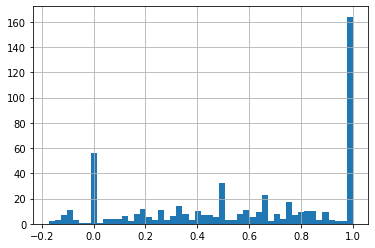

In [214]:
(cluster_0['Pants'] - cluster_0['Tees']).hist(bins = 50)

클러스터 0은 하의(BOTTOMS)가 우위인 가운데 상의, 외투 등이 혼재되어 있다.

<AxesSubplot:>

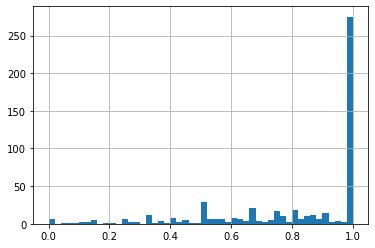

In [215]:
(cluster_0['Pants'] - cluster_0['Knitwear']).hist(bins = 50)

<AxesSubplot:>

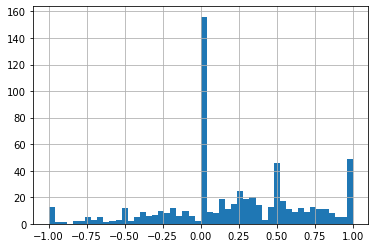

In [408]:
(cluster_0['TOPS'] - cluster_0['OUTWEAR']).hist(bins = 50)

클러스터 0는 패턴 없이 다양한 상품이 혼합되어 있다

In [206]:
cluster_1 = temp_scailing_cluster[
    temp_scailing_cluster['cluster_kmeans'] == 1].iloc[:,1:-1]

cluster_1_power = pd.merge(Series(cluster_1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_1.cumsum().iloc[-1,:] / cluster_1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_1_power[cluster_1_power['power'] > 0.1]

frequency     power
cat_2                         
Tees      850.027733  0.974802
Pants     179.724026  0.206106
Knitwear  121.666760  0.139526

클러스터 1은 하의가 우세인가운데 상의, 외투가 혼합되어 이싸

In [207]:
cluster_2 = temp_scailing_cluster[
    temp_scailing_cluster['cluster_kmeans'] == 2].iloc[:,1:-1]

cluster_2_power = pd.merge(Series(cluster_2.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_2.cumsum().iloc[-1,:] / cluster_2.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_2_power[cluster_2_power['power'] > 0.1]

frequency     power
cat_2                          
Knitwear   489.703277  0.958323
Tees       137.472693  0.269027
Pants      125.121637  0.244856
Cardigans   73.417811  0.143675
Skirts      70.746922  0.138448
Dresses     64.797699  0.126806
Parkas      54.637428  0.106923
Sets        54.183235  0.106034
Jackets     53.028948  0.103775

클러스터 2는 상의가 우세인 가운데 하의, 외투가 혼합되어 있다

In [208]:
cluster_3 = temp_scailing_cluster[
    temp_scailing_cluster['cluster_kmeans'] == 3].iloc[:,1:-1]

cluster_3_power = pd.merge(Series(cluster_3.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_3.cumsum().iloc[-1,:] / cluster_3.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_3_power[cluster_3_power['power'] > 0.1]

frequency     power
cat_2                             
Gloves/Socks  177.275918  0.923312
Tees           25.968916  0.135255
etc            25.827033  0.134516
Pants          24.579687  0.128019
Knitwear       24.218317  0.126137
Others         19.715875  0.102687

<AxesSubplot:>

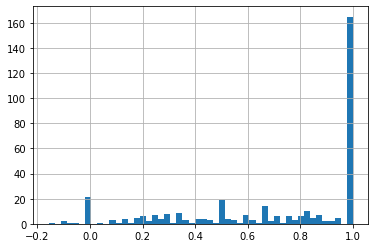

In [406]:
(cluster_3['DRESSES/SETS'] - cluster_3['TOPS']).hist(bins = 50)

<AxesSubplot:>

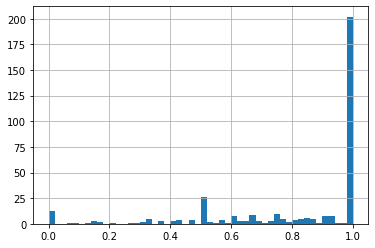

In [409]:
(cluster_3['DRESSES/SETS'] - cluster_3['OUTWEAR']).hist(bins = 50)

<AxesSubplot:>

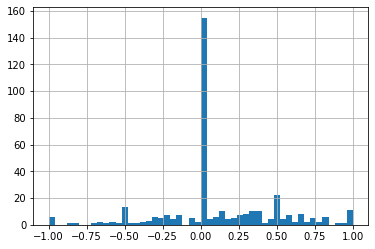

In [410]:
(cluster_3['TOPS'] - cluster_3['OUTWEAR']).hist(bins = 50)

클러스터 3은 세트구매(DRESSES/SETS)가 우위인 가운데 상의, 외투 등이 혼재되어 있다.

In [221]:
cluster_4 = temp_scailing_cluster[
    temp_scailing_cluster['cluster_kmeans'] == 4].iloc[:,1:-1]

cluster_4_power = pd.merge(Series(cluster_4.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_4.cumsum().iloc[-1,:] / cluster_4.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_4_power[cluster_4_power['power'] > 0.1]

frequency     power
cat_2                        
Sets     380.044412  0.950111
Tees      86.433977  0.216085
Dresses   68.347476  0.170869
Pants     59.532720  0.148832

<AxesSubplot:>

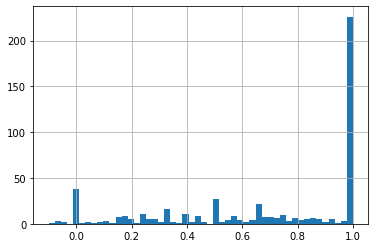

In [407]:
(cluster_4['OUTWEAR'] - cluster_4['TOPS']).hist(bins = 50)

<AxesSubplot:>

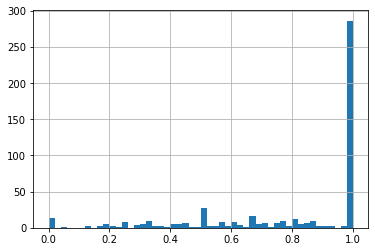

In [411]:
(cluster_4['OUTWEAR'] - cluster_4['BOTTOMS']).hist(bins = 50)

<AxesSubplot:>

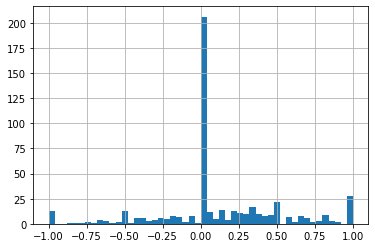

In [412]:
(cluster_4['TOPS'] - cluster_4['BOTTOMS']).hist(bins = 50)

클러스터 4는 외투(OUTWEAR)가 우위인 가운데 상의, 하의등이 혼재되어 있다.

In [219]:
cluster_5 = temp_scailing_cluster[
    temp_scailing_cluster['cluster_kmeans'] == 5].iloc[:,1:-1]

cluster_5_power = pd.merge(Series(cluster_5.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_5.cumsum().iloc[-1,:] / cluster_5.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_5_power[cluster_5_power['power'] > 0.01]

frequency     power
cat_2                                         
Dresses                   135.333424  0.152231
Parkas                    128.367203  0.144395
Hairpin/Band/Brooch        78.901783  0.088753
Cardigans                  67.078939  0.075454
Accessories                58.614040  0.065933
Skirts                     57.521581  0.064704
Coats                      51.934779  0.058419
Boots                      51.330751  0.057740
Denim                      46.894235  0.052749
Blouses                    46.625950  0.052448
Scarf/Muffler              42.466255  0.047769
Others                     40.177239  0.045194
Tees                       38.925513  0.043786
Knitwear                   36.224496  0.040747
flip flops & slides        34.471202  0.038775
Pants                      31.417660  0.035340
Totes                      31.007288  0.034879
etc                        29.045775  0.032672
Shoulder Bags              28.726447  0.032313
Shirts                     28.300680  0.031834
silver                     27.906717  0.031391
Sets                       27.710540  0.031170
Clutches/Wallets           27.096044  0.030479
Crossbody Bags             26.335507  0.029624
ballerina shoes / loafer   25.778805  0.028998
fashion earrings           22.386650  0.025182
fashion necklace           22.048290  0.024801
sneakers                   18.729607  0.021068
fashion ring               18.223626  0.020499
Jackets                    16.668779  0.018750
Vests                      16.194579  0.018217
Ball cap                   15.404263  0.017328
Shoes                      15.118382  0.017006
Knit Dresses/Sets          14.601330  0.016424
Bucket hat                 12.987671  0.014609
Kids hats                  12.625587  0.014202
SHOES&ACC                  11.830660  0.013308
sandals / pumps            11.710964  0.013173
Jewelry                    11.403211  0.012827
Gloves/Socks               10.027779  0.011280
Shoes/Acc                   9.987251  0.011234
slippers/fur slippers       9.842860  0.011072
Leggings                    9.261723  0.010418

In [216]:
cluster_6 = temp_scailing_cluster[
    temp_scailing_cluster['cluster_kmeans'] == 6].iloc[:,1:-1]

cluster_6_power = pd.merge(Series(cluster_6.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_6.cumsum().iloc[-1,:] / cluster_6.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_6_power[cluster_6_power['power'] > 0.1]

frequency     power
cat_2                          
Jackets    172.477778  0.907778
Knitwear    43.104587  0.226866
Tees        42.562590  0.224014
Parkas      33.842578  0.178119
Pants       32.004286  0.168444
Dresses     27.871447  0.146692
Cardigans   23.567634  0.124040
Coats       23.012757  0.121120
Skirts      21.790789  0.114688
Sets        20.355266  0.107133

클러스터 5는 악세사리, 신발 등이 혼재되어 있는 것으로 보인다

In [58]:
def user_user_factorization_model(df_depth1, df_depth2, topic_num, top_k = 2):
    print(topic_num)
    model = KMeans(n_clusters=topic_num,random_state=42)
    model.fit(df_depth1.iloc[:,1:])
    
    doc_topic = model.transform(df_depth1.iloc[:,1:])
    
    cluster_topic = \
    pd.concat([df_depth2['buyerId'].reset_index(drop = True),
               Series(np.argmax(doc_topic, axis = 1), name = 'cluster'),
               Series(np.max(doc_topic, axis = 1), name = 'value')],
             axis = 1)
    csm_score_total = list()
    for k in range(topic_num):
        test = pd.merge(df_depth2,
                        cluster_topic.loc[cluster_topic['cluster'] == k
                                          ,'buyerId'],
                         on = 'buyerId')
        u,s,v = np.linalg.svd(test.iloc[:,1:].to_numpy(), full_matrices = False)
        print(s.astype(int))
        energy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))
        order_matrix_reconstruct = np.dot(u[:,0:energy_where], 
                                          np.dot(np.diag(s[0:energy_where]), 
                                                         v[0:energy_where]))
        csm_cluster = cosine_similarity(order_matrix_reconstruct)
        csm_score = list()
        for buyer_id in test['buyerId']:
            csm_score.append(
                np.mean(
                        user_user_factorization(test, 
                                   int(test[test['buyerId'] == buyer_id].index.values),
                                      csm_cluster,
                                      top_k)
                        )
            )
        csm_score_total.append(np.mean(csm_score))
    return csm_score_total

In [59]:
a = \
[np.mean(user_user_factorization_model(temp_cat1_scailing,
                             temp_cat2_scailing,
                             i)) for i in range(1,5)]

1
[45 23 21 21 16 15 14 14 12 11 11 10 10 10  9  9  8  8  8  7  7  7  7  6
  6  6  5  5  5  5  5  5  4  4  4  4  4  4  4  4  3  3  3  3  3  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  0  0  0  0  0  0  0  0
  0  0  0  0  0]
2
[32 16 15 15 11 11 10 10  9  8  8  8  8  6  6  6  6  6  5  5  5  4  4  4
  4  4  4  3  3  3  3  3  3  3  3  3  3  3  3  2  2  2  2  2  2  2  2  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
[31 16 15 14 11 11 10  9  8  8  7  7  7  7  6  6  6  6  5  5  5  5  5  4
  4  4  4  3  3  3  3  3  3  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2
  2  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
3
[22 11 10 10  8  7  7  7  6  6  6  5  5  5  4  4  4  4  4  3  3  3  3  3
  3  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
[31 16 14 14 11 10 10  9  8  8  7  7  7  6  6  6  

In [60]:
a

[0.9354518564959766,
 0.9257658174682728,
 0.9174204754599039,
 0.9036173612886561]

In [448]:
temp_0 = \
pd.merge(temp.loc[cluster_0.index.values,'buyerId'],
         dataframe_buyer)[['cusumOrderAmount',
                          'cusumPurchaseAmount',
                          'cusumOrderQuantity',
                          'cusumPurchaseQuantity',
                          'sinceLastLogined']]

In [449]:
temp_1 = \
pd.merge(temp.loc[cluster_1.index.values,'buyerId'],
         dataframe_buyer)[['cusumOrderAmount',
                          'cusumPurchaseAmount',
                          'cusumOrderQuantity',
                          'cusumPurchaseQuantity',
                          'sinceLastLogined']]

In [455]:
temp_2 = \
pd.merge(temp.loc[cluster_2.index.values,'buyerId'],
         dataframe_buyer)[['cusumOrderAmount',
                          'cusumPurchaseAmount',
                          'cubsumOrderQuantity',
                          'cusumPurchaseQuantity',
                          'sinceLastLogined']]

In [456]:
temp_3 = \
pd.merge(temp.loc[cluster_3.index.values,'buyerId'],
         dataframe_buyer)[['cusumOrderAmount',
                          'cusumPurchaseAmount',
                          'cusumOrderQuantity',
                          'cusumPurchaseQuantity',
                          'sinceLastLogined']]

In [457]:
temp_4 = \
pd.merge(temp.loc[cluster_4.index.values,'buyerId'],
         dataframe_buyer)[['cusumOrderAmount',
                          'cusumPurchaseAmount',
                          'cusumOrderQuantity',
                          'cusumPurchaseQuantity',
                          'sinceLastLogined']]

In [458]:
temp_5 = \
pd.merge(temp.loc[cluster_5.index.values,'buyerId'],
         dataframe_buyer)[['cusumOrderAmount',
                          'cusumPurchaseAmount',
                          'cusumOrderQuantity',
                          'cusumPurchaseQuantity',
                          'sinceLastLogined']]

In [451]:
temp_1

cusumOrderAmount  cusumPurchaseAmount  cusumOrderQuantity  \
0             137000.0             137000.0                 7.0   
1            7300500.0            1572000.0               447.0   
2             234000.0             222000.0                15.0   
3            9739100.0                  0.0               404.0   
4             537500.0              64000.0                68.0   
...                ...                  ...                 ...   
1054         2075000.0             234000.0                88.0   
1055         2920000.0              25000.0               219.0   
1056           50000.0                  0.0                 5.0   
1057          449000.0                  0.0                39.0   
1058         1996000.0             127000.0               102.0   

      cusumPurchaseQuantity  sinceLastLogined  
0                       7.0                 1  
1                      79.0                 0  
2                      14.0                 0  
3                       0.0                 2  
4                       6.0                 0  
...                     ...               ...  
1054                   10.0                 0  
1055                    3.0                 0  
1056                    0.0                 0  
1057                    0.0                 0  
1058                    7.0                 0  

[1059 rows x 5 columns]

- 클러스터 0은 하의(BOTTOMS)가 우위인 가운데 상의, 외투 등이 혼재되어 있다.
- 클러스터 1은 상의가 우세인 가운데 하의, 외투가 혼합되어 있다
- 클러스터 2는 패턴 없이 다양한 상품이 혼합되어 있다
- 클러스터 3은 세트구매(DRESSES/SETS)가 우위인 가운데 상의, 외투 등이 혼재되어 있다.
- 클러스터 4는 외투(OUTWEAR)가 우위인 가운데 상의, 하의등이 혼재되어 있다.
- 클러스터 5는 악세사리, 신발 등이 혼재되어 있는 것으로 보인다

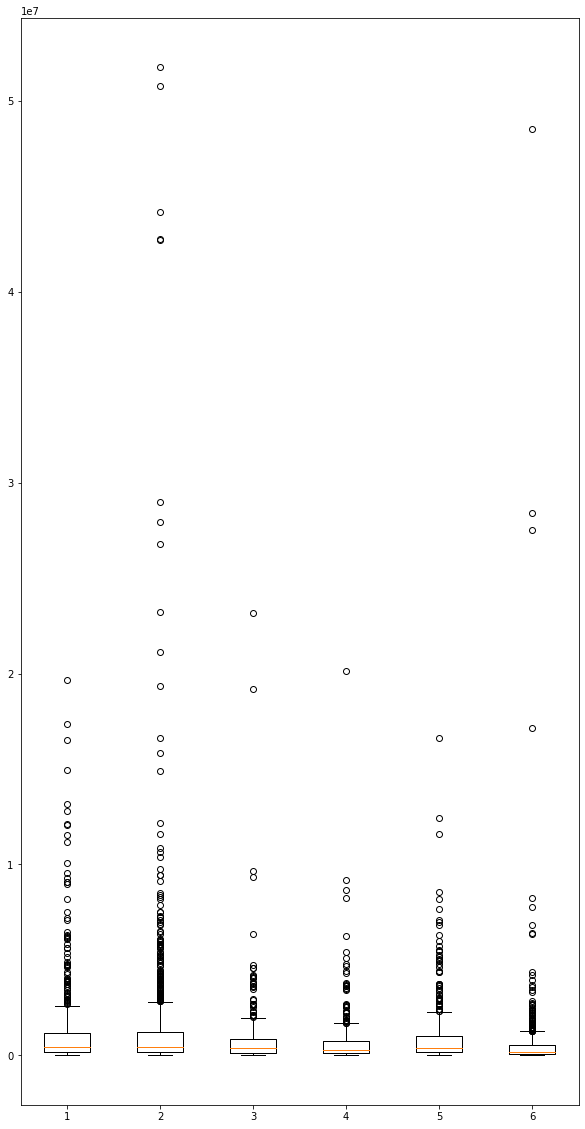

In [480]:
plt.figure(figsize = (10,20))
plt.boxplot([temp_0['cusumOrderAmount'],
             temp_1['cusumOrderAmount'], 
             temp_2['cusumOrderAmount'],
             temp_3['cusumOrderAmount'],
             temp_4['cusumOrderAmount'],
             temp_5['cusumOrderAmount']])
plt.show()

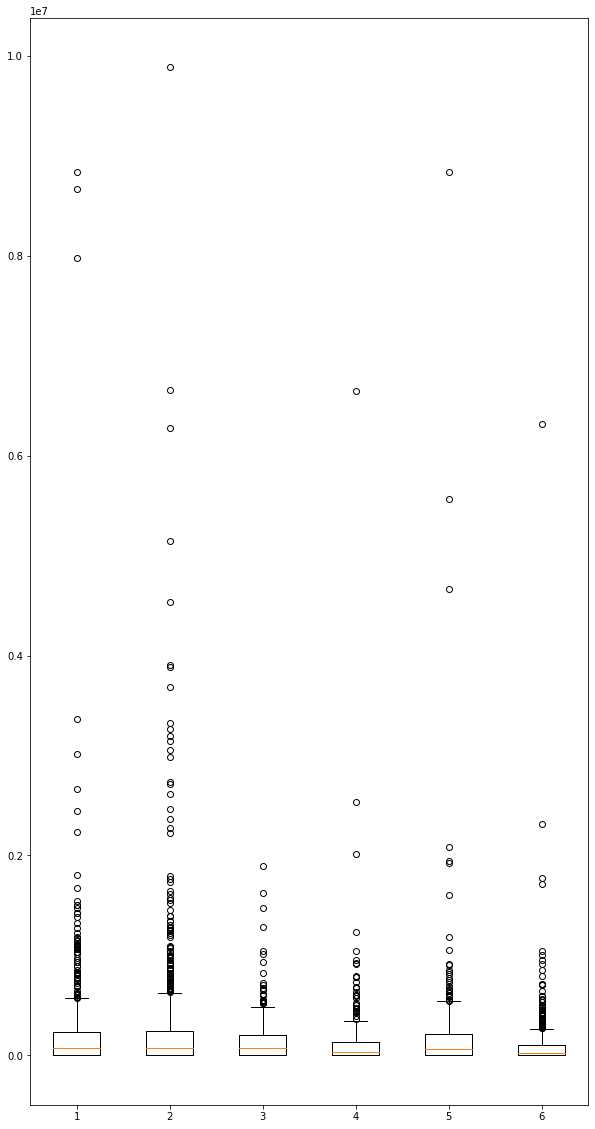

In [481]:
plt.figure(figsize = (10,20))
plt.boxplot([temp_0['cusumPurchaseAmount'],
             temp_1['cusumPurchaseAmount'], 
             temp_2['cusumPurchaseAmount'],
             temp_3['cusumPurchaseAmount'],
             temp_4['cusumPurchaseAmount'],
             temp_5['cusumPurchaseAmount']])
plt.show()

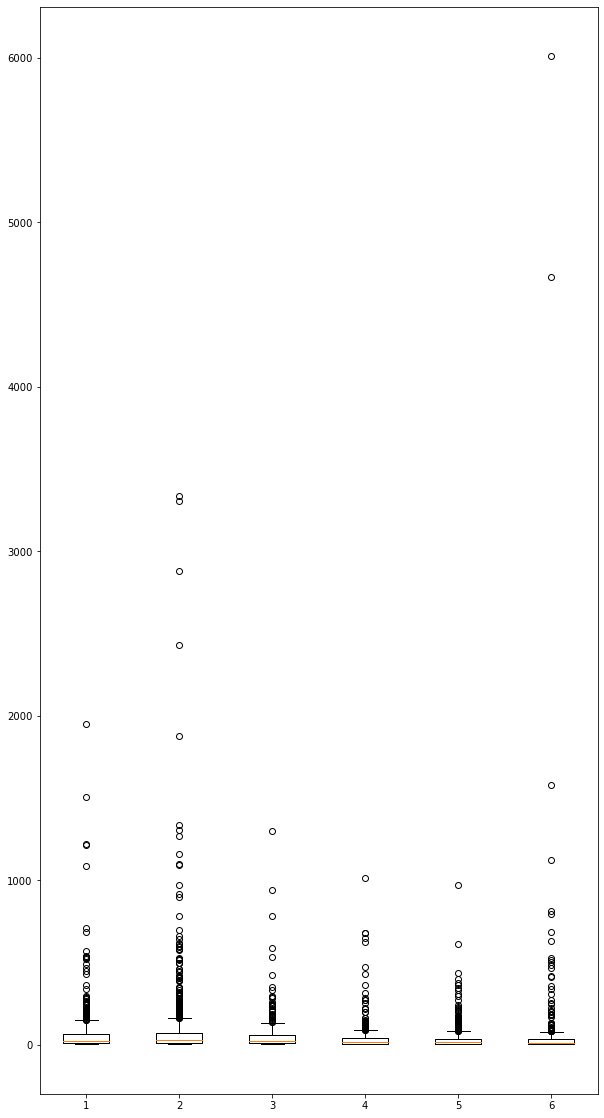

In [482]:
plt.figure(figsize = (10,20))
plt.boxplot([temp_0['cusumOrderQuantity'],
             temp_1['cusumOrderQuantity'], 
             temp_2['cusumOrderQuantity'],
             temp_3['cusumOrderQuantity'],
             temp_4['cusumOrderQuantity'],
             temp_5['cusumOrderQuantity']])
plt.show()

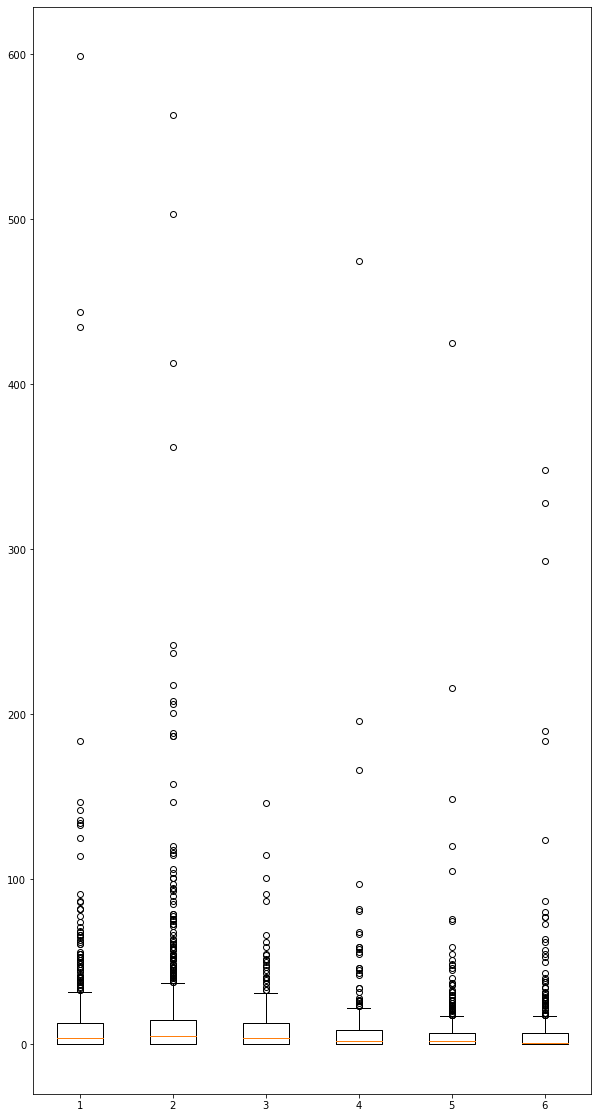

In [483]:
plt.figure(figsize = (10,20))
plt.boxplot([temp_0['cusumPurchaseQuantity'],
             temp_1['cusumPurchaseQuantity'], 
             temp_2['cusumPurchaseQuantity'],
             temp_3['cusumPurchaseQuantity'],
             temp_4['cusumPurchaseQuantity'],
             temp_5['cusumPurchaseQuantity']])
plt.show()

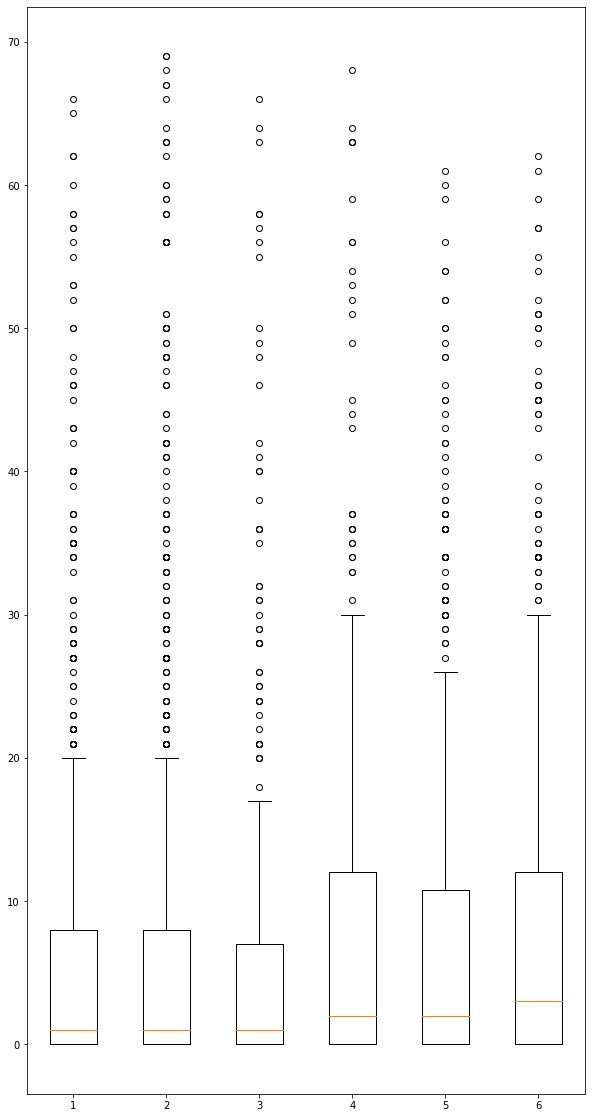

In [484]:
plt.figure(figsize = (10,20))
plt.boxplot([temp_0['sinceLastLogined'],
             temp_1['sinceLastLogined'], 
             temp_2['sinceLastLogined'],
             temp_3['sinceLastLogined'],
             temp_4['sinceLastLogined'],
             temp_5['sinceLastLogined']])
plt.show()

# Data Preprocessing

## Bayes

In [97]:
categories = pd.read_csv('../데이터 추출/BD/BD_카테고리_20230213.csv')

In [113]:
categories['ko'] = categories['name'].apply(lambda x : eval(x)['ko'])

In [115]:
categories[categories['ko'] == '잡화']

id                                               name  parentId  \
346  339  {"en": "Shoes/Acc", "ja": "雑貨", "ko": "잡화", "z...     334.0   
362  262  {"en": "ACCESSORY", "ja": "雑貨", "ko": "잡화", "z...       2.0   

     isActive                      childIds  minKRW  \
346      True                     {347,348}     NaN   
362      True  {51,178,265,177,356,426,430}     NaN   

                                             shortName  unitWeight  \
346  {"en": "Shoes/Acc", "ja": "雑貨", "ko": "잡화", "z...         0.3   
362  {"en": "SHOES&ACC", "ja": "雑貨", "ko": "잡화", "z...         1.0   

                                               aliases  materialGroupId  \
346  {"en": "", "ja": "", "ko": "", "zh-cn": "", "z...            102.0   
362  {"en": "", "ja": "", "ko": "", "zh-cn": "", "z...            102.0   

                                             imagePath  \
346  http://static.cdn.linkshops.com/images/icon/ki...   
362  http://static.cdn.linkshops.com/images/icon/al...   

                                         mainimagepath  ko  
346                                                NaN  잡화  
362  https://static.cdn.linkshops.com/front/resourc...  잡화

In [94]:
temp_cat1_softmax

cat_1      ACCESSORY    Accessories      BEACHWEAR       BIG SIZE  \
0       2.907073e-07   3.934295e-08   5.324489e-09   2.907073e-07   
1       8.302703e-07   2.256909e-06   8.302703e-07   8.302703e-07   
2       4.171367e-03   4.171367e-03   4.171367e-03   4.171367e-03   
3       5.422607e-03   5.422607e-03   5.422607e-03   5.422607e-03   
4       2.603825e-23   2.603825e-23   2.603825e-23   2.603825e-23   
...              ...            ...            ...            ...   
4180    2.234456e-03   1.651052e-02   2.234456e-03   2.234456e-03   
4181    2.216934e-02   2.216934e-02   2.216934e-02   2.216934e-02   
4182    3.314597e-04   3.314597e-04   3.314597e-04   3.314597e-04   
4183   1.845585e-121  1.845585e-121  1.845585e-121  1.845585e-121   
4184    7.765831e-03   7.765831e-03   7.765831e-03   7.765831e-03   

cat_1       BOTTOMS            Bag           Belt        Bottoms  \
0      4.731400e-02   2.907073e-07   5.324489e-09   5.324489e-09   
1      1.232230e-04   8.302703e-07   8.302703e-07   2.256909e-06   
2      4.171367e-03   4.171367e-03   4.171367e-03   6.190857e-01   
3      5.422607e-03   5.422607e-03   5.422607e-03   5.422607e-03   
4      6.897303e-13   2.603825e-23   2.603825e-23   2.603825e-23   
...             ...            ...            ...            ...   
4180   2.234456e-03   2.234456e-03   2.234456e-03   2.234456e-03   
4181   2.216934e-02   2.216934e-02   2.216934e-02   6.026252e-02   
4182   9.880675e-01   3.314597e-04   3.314597e-04   3.314597e-04   
4183   1.000000e+00  1.845585e-121  1.845585e-121  1.845585e-121   
4184   4.240000e-01   7.765831e-03   7.765831e-03   7.765831e-03   

cat_1  Clutches/Wallets  DRESSES & SETS  ...          TOPS           Tops  \
0          5.324489e-09    5.324489e-09  ...  9.503271e-01   5.324489e-09   
1          8.302703e-07    8.302703e-07  ...  9.105020e-04   3.349550e-04   
2          4.171367e-03    4.171367e-03  ...  4.171367e-03   2.277489e-01   
3          5.422607e-03    5.422607e-03  ...  5.422607e-03   5.422607e-03   
4          2.603825e-23    2.603825e-23  ...  2.472623e-03   2.855441e-20   
...                 ...             ...  ...           ...            ...   
4180       2.234456e-03    2.234456e-03  ...  2.234456e-03   2.234456e-03   
4181       2.216934e-02    2.216934e-02  ...  2.216934e-02   2.216934e-02   
4182       3.314597e-04    3.314597e-04  ...  3.314597e-04   3.314597e-04   
4183      1.845585e-121   1.845585e-121  ...  3.761821e-87  1.845585e-121   
4184       7.765831e-03    7.765831e-03  ...  1.559809e-01   7.765831e-03   

cat_1          WOMEN      bracelets       earrings   jewelry etc.  \
0       5.324489e-09   5.324489e-09   5.324489e-09   5.324489e-09   
1       8.302703e-07   2.256909e-06   4.533122e-05   8.302703e-07   
2       4.171367e-03   4.171367e-03   4.171367e-03   4.171367e-03   
3       5.422607e-03   5.422607e-03   8.047862e-01   5.422607e-03   
4       2.603825e-23   2.603825e-23   2.603825e-23   2.603825e-23   
...              ...            ...            ...            ...   
4180    2.234456e-03   2.234456e-03   2.234456e-03   2.234456e-03   
4181    2.216934e-02   2.216934e-02   2.216934e-02   2.216934e-02   
4182    3.314597e-04   3.314597e-04   3.314597e-04   3.314597e-04   
4183   1.845585e-121  1.845585e-121  1.845585e-121  1.845585e-121   
4184    7.765831e-03   7.765831e-03   7.765831e-03   7.765831e-03   

cat_1    men's shoes      necklaces          rings  women's shoes  
0       2.148052e-06   5.324489e-09   5.324489e-09   5.324489e-09  
1       8.302703e-07   8.302703e-07   4.533122e-05   6.134914e-06  
2       4.171367e-03   4.171367e-03   4.171367e-03   4.171367e-03  
3       5.422607e-03   5.422607e-03   5.422607e-03   5.422607e-03  
4       6.289527e-16   2.603825e-23   3.864419e-21   2.603825e-23  
...              ...            ...            ...            ...  
4180    2.234456e-03   6.073882e-03   2.234456e-03   2.234456e-03  
4181    2.216934e-02   2.216934e-02   2.216934e-02   2.2

In [234]:
u,s,v = np.linalg.svd(temp_scailing.iloc[:,1:], full_matrices=False)

In [258]:
np.max(np.where(s.cumsum() / s.sum() < 0.8))

33

In [280]:
s.shape

(77,)

In [282]:
v[0]

array([5.20714666e-02, 1.47568422e-03, 4.69645095e-03, 1.83636069e-03,
       1.77457482e-02, 3.31740391e-03, 4.95570397e-03, 4.59897491e-02,
       5.38372509e-03, 4.04670583e-02, 8.22902796e-05, 1.52493049e-02,
       1.89468949e-04, 1.14963985e-01, 2.41999202e-03, 7.28522280e-03,
       6.53613338e-02, 2.11222641e-02, 2.67874503e-03, 8.80155299e-02,
       1.56466289e-01, 8.97952712e-05, 7.47770765e-02, 4.96373023e-02,
       3.28576688e-03, 1.36948466e-01, 7.47903159e-03, 3.44484156e-03,
       1.29026339e-02, 1.59163116e-02, 1.83026936e-02, 3.67333902e-01,
       7.32329787e-04, 1.43746475e-02, 2.07500605e-04, 6.46223446e-04,
       4.11046534e-02, 3.12984315e-03, 4.68328454e-01, 1.35497928e-01,
       4.36915320e-03, 5.53166950e-03, 3.56306076e-04, 3.66777610e-02,
       1.34419898e-04, 2.28082062e-01, 4.93953415e-02, 1.13606024e-02,
       7.73143824e-03, 2.32533115e-02, 1.17300721e-01, 5.68797463e-04,
       3.55882463e-03, 7.28219780e-03, 6.82860967e-01, 1.68250751e-02,
      

In [284]:
np.argsort(v[0])

array([10, 21, 44, 72, 12, 34, 56, 60, 42, 51, 35, 58, 70, 32, 62, 69, 71,
        1,  3, 14, 18, 37, 24,  5, 61, 27, 52, 64, 40,  2,  6,  8, 41, 67,
       75, 53, 15, 26, 48, 73, 66, 47, 76, 28, 33, 11, 29, 55, 65,  4, 30,
       74, 17, 59, 68, 63, 49, 57, 43,  9, 36,  7, 46, 23,  0, 16, 22, 19,
       13, 50, 39, 25, 20, 45, 31, 38, 54], dtype=int64)

In [288]:
temp_scailing.iloc[:,1:].columns[np.argsort(v[1])]

Index(['Tees', 'Accessories', 'Kids hats', 'Shoes', 'Blouses/Shirts',
       'Ball cap', 'SUITS', 'Outwear', 'fashion bracelets', 'Card holder',
       'Lifestyle', 'WOMEN', 'Sunglasses/Eyewear', 'Bottoms', 'TOPS',
       'brogues & oxfords', 'Eye wear', 'Scarves&Wraps',
       'chelsea boots /boots', 'handmade shoes', 'loafer/ boat shoes',
       'OUTWEAR', 'Leggings', 'pierce', 'BEACHWEAR', 'Snapbacks', 'gold',
       'DRESSES', 'Umbrella', 'Knitwears', 'Clutches/Wallets', 'Shoes/Acc',
       'Hats', 'Belt', 'BOTTOMS', 'Cell Phone/AirPod Case', 'Jumpsuits',
       'Jewelry', 'SHOES&ACC', 'Backpacks/Sling bags', 'Beret/Military cap',
       'chelsea boots / military boots', 'slippers/fur slippers',
       'fashion ring', 'Pearl', 'Totes', 'sneakers', 'etc', 'fashion necklace',
       'flip flops & slides', 'sandals / pumps', 'Crossbody Bags',
       'Shoulder Bags', 'fashion earrings', 'Bucket hat', 'Knit Dresses/Sets',
       'Knit Bottoms', 'Vests', 'ballerina shoes / loafer', 'silv

In [270]:
order_matrix_reconstruct = np.dot(u[:,0:44], np.dot(np.diag(s[0:44]), v[0:44]))

In [271]:
elbows = visualize_elbowmethod(order_matrix_reconstruct)

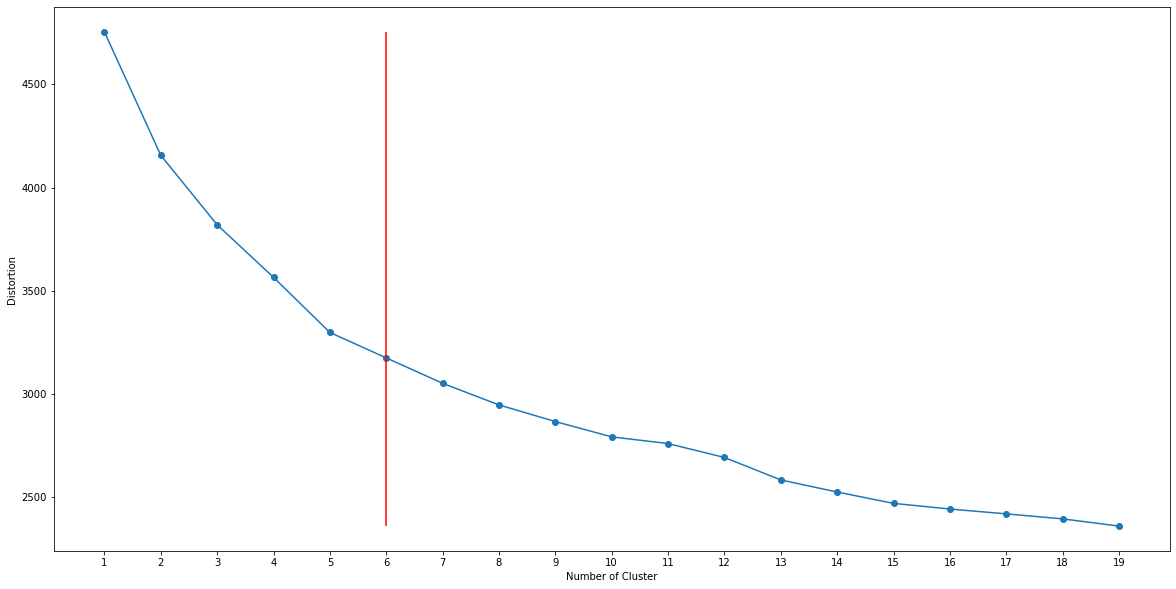

In [272]:
plt.figure(figsize = (20,10))
plt.plot(range(1, 20), elbows, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.xticks(range(0,20))
plt.vlines(6, ymin = min(elbows), ymax = max(elbows), color = 'red')
plt.show()

In [273]:
kmeans = [KMeans(n_clusters = i).fit(DataFrame(order_matrix_reconstruct)) for i in range(1,20)]

bic = [compute_bic(kmeansi, DataFrame(order_matrix_reconstruct)) for kmeansi in kmeans]

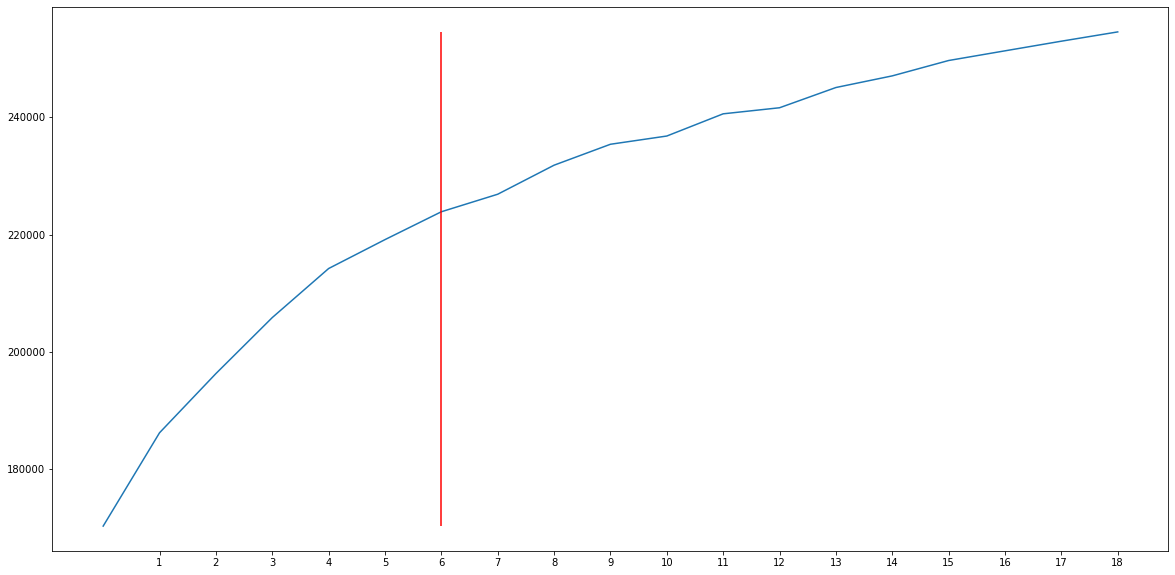

In [274]:
plt.figure(figsize = (20,10))
plt.plot(bic)
plt.xticks(range(1,20))
plt.vlines(6, ymin = min(bic), ymax = max(bic), color = 'red')
plt.show()

# 3. Modeling

## 1) Matrix Factorization

### (1) Singular Value Decomposition

#### - SVD

In [321]:
u,s,v = np.linalg.svd(temp_cat2_scailing.iloc[:,1:].to_numpy(), full_matrices = False)

특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.

In [322]:
np.max(np.where(s.cumsum() / s.sum() < 0.9))

45

위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.

In [323]:
order_matrix_reconstruct = np.dot(u[:,0:44], np.dot(np.diag(s[0:44]), v[0:44]))

In [324]:
csm_total = cosine_similarity(order_matrix_reconstruct)

User - User Matrix Factorization에 기반한 카테고리 유사도 판정 함수를 정의한다.

<파라미터>
1. ind : 타겟 유저 번호(1 ~ 7549)
2. csm : 코사인 유사도 매트릭스
3. k : Top - K번째 유저 정의

<도출값>
1. 코사인 유사도
2. Top - K 유저의 카테고리 목록
3. 타겟 유저와 Top - K 유저의 카테고리 목록 간 교집합
4. 도출된 Top - K 유저의 구매 상품 리스트

In [325]:
temp_cat2_scailing = temp_cat2_scailing.reset_index(drop = True)

In [339]:
def user_user_factorization(df, ind, csm, k, verbose = False):
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
        display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][['prodName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',"\n")
            display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][['prodName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
    return np.sort(csm[ind])[-k:-1]

In [327]:
csm_score = list()
for buyer_id in temp_cat2_scailing['buyerId']:
    csm_score.append(
        np.mean(
                user_user_factorization(temp_cat2_scailing, 
                           int(temp_cat2_scailing[temp_cat2_scailing['buyerId'] == buyer_id].index.values),
                              csm_total,
                              5)
                )
    )

In [340]:
user_user_factorization(temp_cat2_scailing, 
                        int(temp_cat2_scailing[temp_cat2_scailing['buyerId'] == 171078].index.values), 
                        csm_total,
                        3, 
                        verbose = True)

<1. cosine similarity>
userID : 47639.0 -  0.918091758193796
userID : 117567.0 -  0.8295125706822734


<2. Top - K user's Category list>
target - 171078.0 {'flip flops & slides', 'Hats', 'Boots'}
UserID - 47639.0 {'Others', 'Denim', 'Jackets', 'SHOES&ACC', 'Tees', 'Boots', 'flip flops & slides', 'Beret/Military cap'}
UserID - 117567.0 {'flip flops & slides', 'DRESSES', 'ballerina shoes / loafer', 'sandals / pumps', 'Dresses', 'Boots'}


<3. Top - K User's intersection List>
UserID - 47639.0 {'flip flops & slides', 'Boots'}
UserID - 117567.0 {'flip flops & slides', 'Boots'}


<4. Top - K User's Product List>
target - 171078.0 



prodName       cat_0          cat_1  \
60561                         레이스망사해군모  Bucket hat      SHOES&ACC   
264535  Best) HS243-4 스틸레토 리본슬링백 힐 7cm       SHOES  women's shoes   
264541              CM9232-4 스웨이드스판롱부츠       SHOES  women's shoes   

                      cat_2  
60561                  Hats  
264535  flip flops & slides  
264541                Boots

UserID - 47639.0 



prodName                cat_0  \
62411                          22090802            ACCESSORY   
64514                           스티치망토jp                WOMEN   
64515                            웰컴곰돌이t                WOMEN   
64516                              엑스데님                WOMEN   
103631                       도핀 반지갑 풀박스  Leather Accessories   
122712        6361A 천연가죽 스퀘어 미들 통굽 앵클부츠                SHOES   
127994  리얼소가죽 밍크퍼 슬립온or슬라이드 어그부츠-5125-1                SHOES   
228064                            어그슬리퍼                SHOES   
228522                            232-m                SHOES   
254737                           비니 알파카            ACCESSORY   
270626                           벨트데님pt                WOMEN   
270627                          구피언발mtm                WOMEN   

                   cat_1                cat_2  
62411               Hats   Beret/Military cap  
64514            OUTWEAR              Jackets  
64515               TOPS                 Tees  
64516            BOTTOMS                Denim  
103631  Clutches/Wallets            SHOES&ACC  
122712     women's shoes                Boots  
127994     women's shoes                Boots  
228064     women's shoes  flip flops & slides  
228522     women's shoes  flip flops & slides  
254737              Hats               Others  
270626           BOTTOMS                Denim  
270627              TOPS                 Tees

UserID - 117567.0 



prodName          cat_0  \
24781                                         샤인 ops          WOMEN   
25085                                         테드 ops          WOMEN   
81498                     KK 312 바스락 패드 볼레로 CD 뮬 블로퍼          SHOES   
81550                 WS 5108 부츠 하프 아가일 레더 반바지 트임 장화          SHOES   
81551                 DT 4194 나염 데님 오버롤 원피스 점프수트 블로퍼          SHOES   
103693              슬링백 샌들 꼬임1.5cm  재주문1등 그뎌 입고 s212          SHOES   
103694            그디어 오늘밤 입고 슬링백/샌들  1.5cm굽 고급샌들 212          SHOES   
115842                                    8168 트위드샌들  women's shoes   
205389                                           152          SHOES   
212775                                 대박강추))뷰티카라원피스          WOMEN   
217170  22 FW 가을신상) WB-0195 듀란 그린 키높이 통굽 미들 첼시 워커 부츠          SHOES   
231552                                 띠 블로퍼 fl 1038          SHOES   
231554                                   뾰족뮬 fl 1193          SHOES   

                cat_1                     cat_2  
24781    DRESSES/SETS                   Dresses  
25085    DRESSES/SETS                   Dresses  
81498   women's shoes       flip flops & slides  
81550   women's shoes                     Boots  
81551   women's shoes       flip flops & slides  
103693  women's shoes       flip flops & slides  
103694  women's shoes  ballerina shoes / loafer  
115842          SHOES       flip flops & slides  
205389  women's shoes           sandals / pumps  
212775       BIG SIZE                   DRESSES  
217170  women's shoes                     Boots  
231552  women's shoes       flip flops & slides  
231554  women's shoes       flip flops & slides

array([0.82951257, 0.91809176])

## funkSVD